# Notes about simulation:

$$MAP3K_I = MAP3K_t-MAP3K$$
$$MAP2K_I = MAP2K_t-MAP2K$$
$$MAPK_I = MAPK_t-MAPK$$


$$\dfrac{dMAP3K}{dt} = \dfrac{ s}{1+\dfrac{MAPK}{\beta}} \cdot \dfrac{k1\cdot MAP3K_I}{K_1 + MAP3K_I} - \dfrac{k2\cdot MAP3K}{K_2+MAP3K}$$

$$\dfrac{dMAP2K}{dt} = \dfrac{k3\cdot MAP3K\cdot MAP2K_I}{K_3 + MAP2K_I} - \dfrac{k4\cdot MAP2K}{K_4+MAP2K}$$

$$\dfrac{dMAPK}{dt} = \dfrac{k5\cdot MAP2K\cdot MAPK_I}{K_5 + MAPK_I} - \dfrac{k6\cdot MAPK}{K_6+MAPK}$$


# Import packages and set settings

In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
# import math
import pandas as pd
from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import os
import itertools

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

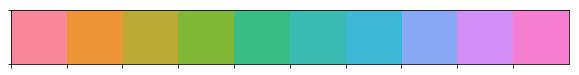

In [4]:
sns.palplot(sns.husl_palette(10, l=.7))
palette_husl = sns.husl_palette(10, l=.7)
# palette_husl.as_hex()
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()

In [5]:
reds = sns.color_palette("Reds",15)
reds.as_hex()

['#feeae1',
 '#fee0d2',
 '#fdcdb9',
 '#fcbba1',
 '#fca689',
 '#fc9272',
 '#fb7d5d',
 '#fb694a',
 '#f5523a',
 '#ee3a2c',
 '#dc2924',
 '#ca181d',
 '#b71319',
 '#a30f15',
 '#840711']

# Supporting Functions

In [11]:
# def load_csv_data(folder):
#     data = []
#     for csv in pathlib.Path(folder).glob('*.csv'):
#         f_data = pd.read_csv(csv)
#         time = f_data['Time'].tolist()
#         f_data=f_data.set_index('Time')
#         f_data = f_data.mean(axis=1)
#         f_data = f_data.tolist()
#         data.append(f_data)
#     return time, data

# def get_closest_tps(scorefxn_time,time):
#     idx_closest_time_points = []
#     for each_time in scorefxn_time:
#         closest_idx = min(range(len(time)),
#                           key = lambda i: abs(time[i] - each_time))
#         idx_closest_time_points.append(closest_idx)
#     return idx_closest_time_points

# # def convert_individual(ea_individual, conversion_matrix, number_of_params):
#     # copy and get len of individual
#     arr_params_conv = np.zeros(number_of_params)#np.copy(arr_parameters)
#     len_ind = len(ea_individual)

#     # Interp:
#     for idx in np.nonzero(conversion_matrix[0])[0]:
#         ea_val = ea_individual[idx]
#         r_min = conversion_matrix[1][idx]
#         r_max = conversion_matrix[2][idx]
#         arr_params_conv[idx] = np.interp(ea_val, (0,1), (r_min, r_max))

#     # Exponentiate:
#     for idx in np.nonzero(conversion_matrix[3])[0]:
#         ea_val = arr_params_conv[idx]
#         base_val = conversion_matrix[4][idx]
#         arr_params_conv[idx] = np.power(base_val, ea_val)

#     # arr_params_conv[-4:] = np.round(arr_params_conv[-4:],0)

#     return arr_params_conv

# def scorefxn2(scorefxn_data, inits, params_constants,
#               learned_params, time, scorefxn_time):
#     sse_total = 0
# #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

#     for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
#         params_constants_sig = params_constants[:-1]+[sig]

#         for fxn, exp_data in zip([simulate_wt_experiment,simulate_t100a_experiment],[MAPK_wt_data, MAPK_t100a_data]):
#             data = fxn(inits, params_constants_sig, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             _scorefxn_data_active = active[[scorefxn_time]]
#             error_active = ((exp_data - _scorefxn_data_active)**2).sum()
#             sse_total += error_active
#     return sse_total/(len(idx_closest_time_points)*len(params_constants[-1])-len(learned_params))

# def scorefxn1(scorefxn_data, inits, params_constants,
#               learned_params, time, scorefxn_time):
#     sse_total = 0
# #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

#     for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
#         params_constants_sig = params_constants[:-1]+[sig]

#         for fxn, exp_data in zip([simulate_wt_experiment,simulate_t100a_experiment],[MAPK_wt_data, MAPK_t100a_data]):
#             data = fxn(inits, params_constants_sig, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             _scorefxn_data_active = active[[scorefxn_time]]
#             error_active = ((exp_data - _scorefxn_data_active)**2).mean()
#             sse_total += error_active
#     return sse_total

# def molarity_conversion(molecules):
#     Na = 6.02214076*10**23
#     cell_volume = 44
#     return molecules/(Na*cell_volume*10**-15)*1000000

# def gather_simulated_data(folder, gen, runs, top_plotting):
#     mse = []
#     params_from_file = []

#     empty_data = 0
#     for loaded_data in pathlib.Path(folder).glob('*.pickled'):
#         if os.path.getsize(loaded_data) > 0:
#             with open(loaded_data, 'rb') as f:
#                 new_data = pickle.load(f)
#                 mse.append(np.asarray(new_data[0]))
#                 params_from_file.append(np.asarray(new_data[1]))
#         else:
#             empty_data += 1

#     top = round((runs-empty_data)*top_plotting)
#     plt_top = round((runs-empty_data)*top_plotting)      

#     new_params = []
#     last_mses = []
#     for i in range(len(params_from_file)):
#         new_params.append(params_from_file[i][gen])
#         last_mses.append(mse[i][gen])
#     last_mses = np.asarray(last_mses)
# #     last_mses = last_mses
#     new_params = np.asarray(new_params)
#     new_params = new_params.T

#     idx_top = last_mses.argsort()[:top]

#     top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
#     # top_params = []
#     # for idx in idx_top:
#     #     top_params.append(params_from_file[idx][100])

#     print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
#     print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
#     return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses

# def plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
#                         params_constants, initals, time):
#     plt.clf()
#     fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


#     # plot 1
#     title_text = 'Gen ' + str(gen) + ' fit to WT'
#     ax1.set_title(title_text, fontsize=20)
#     ax1.set_xlabel('Time', fontsize=20)
#     plt.rc('xtick', labelsize=20) 
#     plt.rc('ytick', labelsize=20)
#     color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
#     for sig, wt_data in zip(params_constants[-1], mapk_wt_data):
#         ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette.get(sig))
        
#     # plot 2
#     title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
#     ax2.set_title(title_text, fontsize=20)
#     ax2.set_xlabel('Time', fontsize=20)
    
#     for sig, t100a_data in zip(params_constants[-1], mapk_t100a_data):
#         ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette.get(sig))

#     # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
#     # plot evolutionary algorithm data on plots 1 and 2:
#     unstable_wt = 0
#     unstable_t100a = 0
#     for idx in idx_top[:plt_top]:
#         learned_params = params_from_file[idx][gen]
#         for sig in params_constants[-1]:
#             params_c = params_constants[:-1]
#             data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, None, None)
#             active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax1.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_wt += 1
#             data = simulate_t100a_experiment(initals, params_c, sig, learned_params, time, None, None)
#             active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax2.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_t100a += 1
#     print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
#     print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
#     # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.show()
    
# def plt_param_behaviors_map2k(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
#                         params_constants, initals, time):
#     plt.clf()
#     fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


#     # plot 1
#     title_text = 'Gen ' + str(gen) + ' fit to WT'
#     ax1.set_title(title_text, fontsize=20)
#     ax1.set_xlabel('Time', fontsize=20)
#     plt.rc('xtick', labelsize=20) 
#     plt.rc('ytick', labelsize=20)
#     color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
#     for sig, wt_data in zip(params_constants[-1], mapk_wt_data):
#         ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette.get(sig))
        
#     # plot 2
#     title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
#     ax2.set_title(title_text, fontsize=20)
#     ax2.set_xlabel('Time', fontsize=20)
    
#     for sig, t100a_data in zip(params_constants[-1],mapk_t100a_data):
#         ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette.get(sig))

#     # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
#     # plot evolutionary algorithm data on plots 1 and 2:
#     unstable_wt = 0
#     unstable_t100a = 0
#     for idx in idx_top[:plt_top]:
#         learned_params = params_from_file[idx][gen]
#         for sig in params_constants[-1]:
#             params_c = params_constants[:-1]
#             data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, None, None)
#             active = data[:,1]/params_constants[1]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax1.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_wt += 1
#             data = simulate_t100a_experiment(initals,params_c, sig, learned_params, time, None, None)
#             active = data[:,1]/params_constants[1]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax2.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_t100a += 1
#     print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
#     print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
#     # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.show()
    
# def plt_param_behaviors_pulse(mapk_wt_data, map2k_wt_data, gen, idx_top, plt_top, params_from_file, 
#                         params_constants, initals, time):
#     plt.clf()
#     fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


#     # plot 1
#     title_text = 'Gen ' + str(gen) + ' MAPK'
#     ax1.set_title(title_text, fontsize=20)
#     ax1.set_xlabel('Time', fontsize=20)
#     plt.rc('xtick', labelsize=20) 
#     plt.rc('ytick', labelsize=20)
#     color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
#     for sig, wt_data in zip([550000], mapk_wt_data):
#         ax1.plot(mapk_pulse_time, wt_data, 'o', markersize=10, color=color_palette.get(sig))
        
#     # plot 2
#     title_text = 'Gen ' + str(gen) +  ' MAP2K'
#     ax2.set_title(title_text, fontsize=20)
#     ax2.set_xlabel('Time', fontsize=20)
    
#     for sig, map2k_data in zip([550000],map2k_wt_data):
#         ax2.plot(mapk_pulse_time, map2k_data, '^', mew=2, markersize=10, color=color_palette.get(sig))

#     # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
#     # plot evolutionary algorithm data on plots 1 and 2:
#     for idx in idx_top[:plt_top]:
#         learned_params = params_from_file[idx][gen]
#         for sig in [550000]:
#             params_c = params_constants[:-1]
#             data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, signal_periodic, 10)
#             active = data[:,2]/params_constants[2]*100
#             ax1.plot(time, active, color=color_palette.get(sig))
#             pbs2 = data[:,1]/params_constants[1]*100
# #             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#             ax2.plot(time, pbs2, color=color_palette.get(sig))
#     # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.show()
    
# def plt_prediction(gen, idx_top, plt_top, params_from_file,params_constants, initals, time):
#     plt.clf()
#     fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


#     # plot 1
#     title_text = 'Gen ' + str(gen) + ' fit to WT'
#     ax1.set_title(title_text, fontsize=20)
#     ax1.set_xlabel('Time', fontsize=20)
#     plt.rc('xtick', labelsize=20) 
#     plt.rc('ytick', labelsize=20)
#     color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
        
#     # plot 2
#     title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
#     ax2.set_title(title_text, fontsize=20)
#     ax2.set_xlabel('Time', fontsize=20)
    

#     # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
#     # plot evolutionary algorithm data on plots 1 and 2:
#     unstable_wt = 0
#     unstable_t100a = 0
#     for idx in idx_top[:plt_top]:
#         learned_params = params_from_file[idx][gen]
#         for sig in params_constants[-1]:
#             params_c = params_constants[:-1]+[sig]
#             data = simulate_wt_experiment(initals, params_c, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax1.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_wt += 1
#             data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax2.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_t100a += 1
#     print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
#     print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
#     # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.show()
    
# def plt_X_behaviors(gen, idx_top, plt_top, params_from_file, 
#                         params_constants, initals, time):
#     plt.clf()
#     fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


#     # plot 1
#     title_text = 'Gen ' + str(gen) + ' X behavior in to WT'
#     ax1.set_title(title_text, fontsize=20)
#     ax1.set_xlabel('Time', fontsize=20)
#     plt.rc('xtick', labelsize=20) 
#     plt.rc('ytick', labelsize=20)
#     color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
        
#     # plot 2
#     title_text = 'Gen ' + str(gen) +  ' X behavior in T100A + inhib'
#     ax2.set_title(title_text, fontsize=20)
#     ax2.set_xlabel('Time', fontsize=20)

#     # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
#     # plot evolutionary algorithm data on plots 1 and 2:
#     unstable_wt = 0
#     unstable_t100a = 0
#     for idx in idx_top[:plt_top]:
#         learned_params = params_from_file[idx][gen]
#         for sig in params_constants[-1]:
#             params_c = params_constants[:-1]
#             data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, None, None)
#             active = data[:,3]
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax1.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_wt += 1
#             data = simulate_t100a_experiment(initals, params_c, sig, learned_params, time, None, None)
#             active = data[:,3]
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax2.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_t100a += 1
#     print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
#     print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
#     # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.show()
    
#     #plot3 
# def plt_mses_gen(gen,mse):
#     plt.clf()
#     fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
#     colors2 = sns.color_palette("Greys", 20)[10:]
#     pal2 = sns.set_palette(colors2)
#     ax3.set_xlabel('Generation', fontsize=20)
#     for idx in idx_top:
#         ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
#     ax3.yaxis.grid(True)
#     ax3.set_ylabel('SSE', fontsize=20)
#     ax3.set_xlim([0,gen])
# #     ax3.set_ylim([10**3,10**5])
#     plt.show()
    

# def plot_param_ranges(colors3, labelnames, diff, minimums, df_top_params_log_M):
#     plt.rcParams['figure.figsize'] = [12.0, 8.0]

#     pal3 = sns.set_palette(colors3)

#     with sns.axes_style("whitegrid"):
#         plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
#         x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
#         x.set_xticklabels(labelnames,rotation=45)
#     #     ax.set_yscale("log")
#     #     ax.set_ylim(0.00001,100000)
#     #     ax4.set_xticks(locs)
#     #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
#         plt.xlabel('Parameters', fontsize=20)
#         plt.ylabel('Learned parameter values (base 10)', fontsize=20)
#     #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
#         plt.show()
        

# def plot_mses(labelnames, mses, top_p, colors, title):
#     mses = [x.copy() for x in mses]
#     top = len(mses[0])*top_p
#     top_mses = [np.sort(x)[:int(top)] for x in mses]
#     df_mses = pd.DataFrame(top_mses).T
#     df_mses.columns = labelnames
#     df_mses_M = df_mses.melt(var_name='model', value_name='vals')

#     pal = sns.set_palette(colors)
#     with sns.axes_style("whitegrid"):
#         x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
#         x.set_xticklabels(labelnames,rotation=45)
#     #     ax.set_yscale("log")
#     #     ax.set_ylim(0.00001,100000)
#     #     ax4.set_xticks(locs)
#     #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
#         plt.xlabel('Models', fontsize=20)
#         plt.ylabel('SMSE', fontsize=20)
#     #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
#         plt.title('SMSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
# #     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
# #         plt.show()

# # def get_synthdata(data, ):
    
# def get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,num):
#     opt_tps = list(itertools.chain.from_iterable(opt_data_mapk.values()))
#     smse = []
#     for params in top_params[:num]:
#         smse_total = 0
#         #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

#         for sig, tps, MAPK_wt_data in zip(list(opt_data_mapk.keys()), list(opt_data_mapk.values()), wt_data_synth):
#             params_constants_sig = params_constants[:-1]+[sig]
#             for fxn in [simulate_wt_experiment]:
#                 data = fxn(initals, params_constants_sig, params, tps)
#                 active = data[:,2]/params_constants[2]*100
#         #         print(MAPK_wt_data, active)
#                 error_active = ((MAPK_wt_data - active)**2).mean()
#                 smse_total += error_active
#                 if sig == 550000:
#                     data = fxn(initals, params_constants_sig, params, mapk_time)
#                     map2k = data[:,1]/params_constants[1]*100
#                     if any(x > 20 for x in map2k):
#     #                     print(map2k)
#                         continue
#                     else:
#                         smse_total += 5000
#         smse.append(smse_total)
#     idx_synth_param = sorted(range(len(smse)), key=lambda k: smse[k])
#     return top_params[idx_synth_param[0]]

In [34]:
def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

def get_closest_tps(scorefxn_time,time):
    idx_closest_time_points = []
    for each_time in scorefxn_time:
        closest_idx = min(range(len(time)),
                          key = lambda i: abs(time[i] - each_time))
        idx_closest_time_points.append(closest_idx)
    return idx_closest_time_points

# def convert_individual(ea_individual, conversion_matrix, number_of_params):
    # copy and get len of individual
    arr_params_conv = np.zeros(number_of_params)#np.copy(arr_parameters)
    len_ind = len(ea_individual)

    # Interp:
    for idx in np.nonzero(conversion_matrix[0])[0]:
        ea_val = ea_individual[idx]
        r_min = conversion_matrix[1][idx]
        r_max = conversion_matrix[2][idx]
        arr_params_conv[idx] = np.interp(ea_val, (0,1), (r_min, r_max))

    # Exponentiate:
    for idx in np.nonzero(conversion_matrix[3])[0]:
        ea_val = arr_params_conv[idx]
        base_val = conversion_matrix[4][idx]
        arr_params_conv[idx] = np.power(base_val, ea_val)

    # arr_params_conv[-4:] = np.round(arr_params_conv[-4:],0)

    return arr_params_conv

def scorefxn2(scorefxn_data, inits, params_constants,
              learned_params, time, scorefxn_time):
    sse_total = 0
#     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

    for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
        params_constants_sig = params_constants[:-1]+[sig]

        for fxn, exp_data in zip([simulate_wt_experiment,simulate_t100a_experiment],[MAPK_wt_data, MAPK_t100a_data]):
            data = fxn(inits, params_constants_sig, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            _scorefxn_data_active = active[[scorefxn_time]]
            error_active = ((exp_data - _scorefxn_data_active)**2).sum()
            sse_total += error_active
    return sse_total/(len(idx_closest_time_points)*len(params_constants[-1])-len(learned_params))

def scorefxn1(scorefxn_data, inits, params_constants,
              learned_params, time, scorefxn_time):
    sse_total = 0
#     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

    for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
        params_constants_sig = params_constants[:-1]+[sig]

        for fxn, exp_data in zip([simulate_wt_experiment,simulate_t100a_experiment],[MAPK_wt_data, MAPK_t100a_data]):
            data = fxn(inits, params_constants_sig, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            _scorefxn_data_active = active[[scorefxn_time]]
            error_active = ((exp_data - _scorefxn_data_active)**2).mean()
            sse_total += error_active
    return sse_total

def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44
    return molecules/(Na*cell_volume*10**-15)*1000000

def gather_simulated_data(folder, gen, runs, top_plotting):
    mse = []
    params_from_file = []

    empty_data = 0
    for loaded_data in pathlib.Path(folder).glob('*.pickled'):
        if os.path.getsize(loaded_data) > 0:
            with open(loaded_data, 'rb') as f:
                new_data = pickle.load(f)
                mse.append(np.asarray(new_data[0]))
                params_from_file.append(np.asarray(new_data[1]))
        else:
            empty_data += 1

    top = round((runs-empty_data)*top_plotting)
    plt_top = round((runs-empty_data)*top_plotting)      

    new_params = []
    last_mses = []
    for i in range(len(params_from_file)):
        new_params.append(params_from_file[i][gen])
        last_mses.append(mse[i][gen])
    last_mses = np.asarray(last_mses)
#     last_mses = last_mses
    new_params = np.asarray(new_params)
    new_params = new_params.T

    idx_top = last_mses.argsort()[:top]

    top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
    # top_params = []
    # for idx in idx_top:
    #     top_params.append(params_from_file[idx][100])

    print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
    print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
    return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses

def plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
    title_text = 'Best fits to WT kinase dose data'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('% phosopho-MAPK', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
    for sig, wt_data in zip([0, 50000, 150000, 250000, 350000, 450000, 550000], mapk_wt_data):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette.get(sig), label = str(int(sig/1000))+'mM KCl')
    ax1.legend()
        
    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('% phosopho-MAPK', fontsize=16)
    
    for sig, t100a_data in zip([0, 50000, 150000, 250000, 350000, 450000, 550000], mapk_t100a_data):
        ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette.get(sig))

#     ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in doses:
            params_c = params_constants
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, sig, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Desktop/best_fits.png",dpi=300)
    plt.show()
    
def plt_param_behaviors_map2k(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
    title_text = 'Best fits to WT kinase dose data'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('% phosopho-MAP2K', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
    for sig, wt_data in zip([150000, 550000], mapk_wt_data):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette.get(sig), label = str(int(sig/1000))+'mM KCl')
    ax1.legend()
        
    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('% phosopho-MAP2K', fontsize=16)
    
    for sig, t100a_data in zip([150000, 550000], mapk_t100a_data):
        ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette.get(sig))

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in [150000, 550000]:
            params_c = params_constants
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time)
            active = data[:,1]/params_constants[1]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_wt += 1
            data = simulate_t100a_experiment(initals,params_c, sig, learned_params, time)
            active = data[:,1]/params_constants[1]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()

    
def plt_prediction(gen, idx_top, plt_top, params_from_file,params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


    # plot 1
    title_text = 'Gen ' + str(gen) + ' fit to WT'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
        
    # plot 2
    title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=20)
    

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in params_constants[-1]:
            params_c = params_constants[:-1]+[sig]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=color_palette.get(sig))
            else:
                unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()
    
def plt_X_behaviors(gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
    title_text = 'Best fits to WT kinase dose data'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('X (uM)', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
        
    # plot 2
    title_text = 'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('X (uM)', fontsize=16)

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in [0, 150000, 550000]:
            params_c = params_constants[:-1] + [sig]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time)
            active = data[:,3]
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax1.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, sig, learned_params, time)
            active = data[:,3]
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax2.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()
    
    #plot3 
def plt_mses_gen(gen,mse):
    plt.clf()
    fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
    colors2 = sns.color_palette("Greys", 20)[10:]
    pal2 = sns.set_palette(colors2)
    ax3.set_xlabel('Generation', fontsize=20)
    for idx in idx_top:
        ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_ylabel('SSE', fontsize=20)
    ax3.set_xlim([0,gen])
#     ax3.set_ylim([10**3,10**5])
    plt.show()
    

def plot_param_ranges(colors3, labelnames, diff, minimums, df_top_params_log_M):
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    pal3 = sns.set_palette(colors3)

    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
        x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Parameters', fontsize=20)
        plt.ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.show()
        

def plot_mses(labelnames, mses, top_p, colors, title):
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('SMSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('SMSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
#         plt.show()

# def get_synthdata(data, ):
    
def get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,num):
    opt_tps = list(itertools.chain.from_iterable(opt_data_mapk.values()))
    smse = []
    for params in top_params[:num]:
        smse_total = 0
        #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

        for sig, tps, MAPK_wt_data in zip(list(opt_data_mapk.keys()), list(opt_data_mapk.values()), wt_data_synth):
            params_constants_sig = params_constants[:-1]+[sig]
            for fxn in [simulate_wt_experiment]:
                data = fxn(initals, params_constants_sig, params, tps)
                active = data[:,2]/params_constants[2]*100
        #         print(MAPK_wt_data, active)
                error_active = ((MAPK_wt_data - active)**2).mean()
                smse_total += error_active
                if sig == 550000:
                    data = fxn(initals, params_constants_sig, params, mapk_time)
                    map2k = data[:,1]/params_constants[1]*100
                    if any(x > 20 for x in map2k):
    #                     print(map2k)
                        continue
                    else:
                        smse_total += 5000
        smse.append(smse_total)
    idx_synth_param = sorted(range(len(smse)), key=lambda k: smse[k])
    return top_params[idx_synth_param[0]]

def plt_param_behaviors_ramp(hog1_ramp_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
    title_text = 'Best fits to WT kinase dose data'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('% phosopho-MAPK', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
#     for wt_data in mapk_wt_data:
    ax1.plot(mapk_ramp_time, hog1_ramp_data, 'o', markersize=10, color='black')
        
    # plot 2
#     title_text = 'Best fits to WT kinase dose data'
#     ax2.set_title(title_text, fontsize=20)
#     ax2.set_xlabel('Time', fontsize=16)
#     ax2.set_ylabel('% phosopho-MAP2K', fontsize=16)
    
#     for sig, map2k_data in zip(params_constants[-1],map2k_wt_data):
#         ax2.plot(scorefxn_time[1], map2k_data, '^', mew=2, markersize=10, )

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        params_c = params_constants
        data = simulate_ramp_experiment(initals, params_c,learned_params, time)
        active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
        ax1.plot(time, active)
        map2k = data[:,1]/params_constants[1]*100
#         if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
        ax2.plot(time, map2k)
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    ax1.set_ylim(0,100)
    ax2.set_ylim(0,100)
    plt.show()

In [7]:
def plt_X_behaviors_pulse(gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1) = plt.subplots(2, 1, figsize=(12,9))


    # plot 1
    title_text = 'Gen ' + str(gen) + ' X'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
#     for sig, wt_data in zip(params_constants[-1], mapk_wt_data):
#         ax1.plot(scorefxn_time[2], wt_data, 'o', markersize=10, color=color_palette.get(sig))

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in params_constants[-1]:
            params_c = params_constants[:-1]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, signal_periodic, 10)
            active = data[:,3]/params_constants[3]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette.get(sig))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()

In [8]:
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
#     if t_step >= 40:
#         sig = 600000
    return sig
plt.plot(time,[signal_ramp_special(x) for x in time])

NameError: name 'time' is not defined

# Load data to fit to

In [ ]:
base_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/'
# base_folder = '/nas/longleaf/home/sksuzuki/HOG_model/data_pbs2/'

def get_data(base_folder):
    extracted_data = []
    extracted_time = []
    for i, data_folder in enumerate(pathlib.Path(base_folder).glob('**/'), start =1):
        dose_data = []
        for i, csv in enumerate(pathlib.Path(data_folder).glob('*.csv'), start = 1):
            # if csv:
            # new_data = np.genfromtxt(csv, dtype=float, delimiter=',', names=True)
            f_data = pd.read_csv(csv)
            time = f_data['Time'].tolist()
            f_data=f_data.set_index('Time')
            f_data = f_data.mean(axis=1)
            f_data = f_data.tolist()
            dose_data.append(f_data)
        if dose_data:
            extracted_data.append(dose_data)
            extracted_time.append(time)
    return [extracted_data, extracted_time]

scorefxn_data, scorefxn_time = get_data(base_folder)

In [10]:
wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
# sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
# ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
hog1_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
# pbs2_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/pulse_pbs2'

def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

mapk_time, mapk_wt_data = load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)
mapk_time, map2k_wt_data = load_csv_data(pbs2_folder)
mapk_time, map2k_t100a_data = load_csv_data(pbs2_t100a_folder)
# mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
# mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
mapk_ramp_time, hog1_ramp_data = load_csv_data(hog1_ramp_folder)
# mapk_pulse_time, pbs2_pulse_data = load_csv_data(pbs2_pulse_folder)

# hog1_pulse_data = hog1_pulse_data[0]
# pbs2_pulse_data = pbs2_pulse_data[0]


scorefxn_data = [mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data]
scorefxn_time = [mapk_time,mapk_ramp_time]

In [9]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)

# idx_closest_time_points = get_closest_tps(mapk_time,time)

# One Step Delay

## AN

### Functions

In [67]:
def b3_aN_1D_X(initals,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = total_protein
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_aN_1D_X, inits, time, args=(total_protein, sig, learned_params))

    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
#     MAP3K_t, MAP2K_t, MAPK_t, fb, s= total_protein
#     total_protein = MAP3K_t, MAP2K_t, MAPK_t, 0, s

    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(b3_aN_1D_X, inits, time, args=(total_protein, sig, learned_params))

    return odes

def b3_aN_1D_ramp(initals,t,total_protein,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = total_protein
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    sig = signal_ramp_special(t)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_aN_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

In [ ]:
def signal_periodic(t_step, signal, period):
    if t_step == 0:
        s = 0
    elif t_step >= 60:
        s = 0
    elif t_step >= 30:
        s = 0
    elif np.floor(t_step / period) % 2 == 0:
        s =  signal
    else:
        s = 0
    return s

### Inputs

In [58]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/1_pass/181025_b3_1D_a1/'
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190304_aN_map2k_ramp/'
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190304_a1_map2k_ramp/'

run_name = 'b3_1D_a1'
gen = 1000
runs = 2000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)

s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', 
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-4, 
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 4,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t] 

### Gather simulated data

In [59]:
idx_top, top_params_aN_1D, top, plt_top, new_params, params_from_file, mse_aN_1D, last_mses_aN_1D = gather_simulated_data(folder, gen, runs, 0.05)
df_top_params = pd.DataFrame(top_params_aN_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 2483.561790850269
Mean MSE of top 5%: 3043.8201545681936


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 720x576 with 0 Axes>

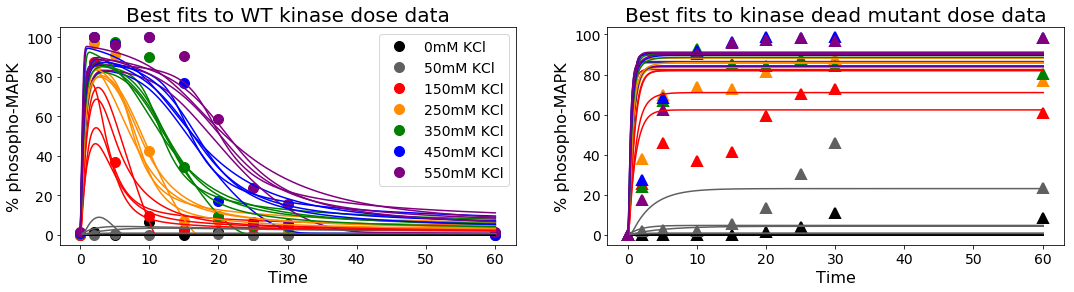

In [62]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# of unstable WT experiments: 0 of 60
# of unstable T100A experiments: 0 of 60


<Figure size 720x576 with 0 Axes>

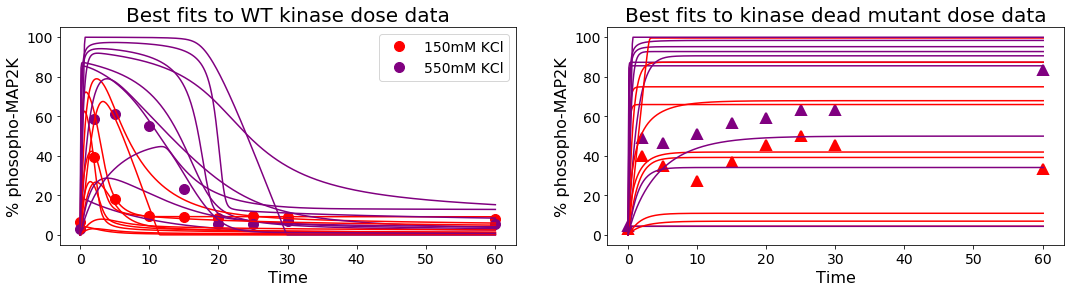

In [68]:
map2k_s = [150000, 550000]
params_constants_map2k = [MAP3K_t, MAP2K_t, MAPK_t, ] 
plt_param_behaviors_map2k(map2k_wt_data, map2k_t100a_data, gen, idx_top, 10, params_from_file, 
                        params_constants_map2k, initals, time)

<Figure size 720x576 with 0 Axes>

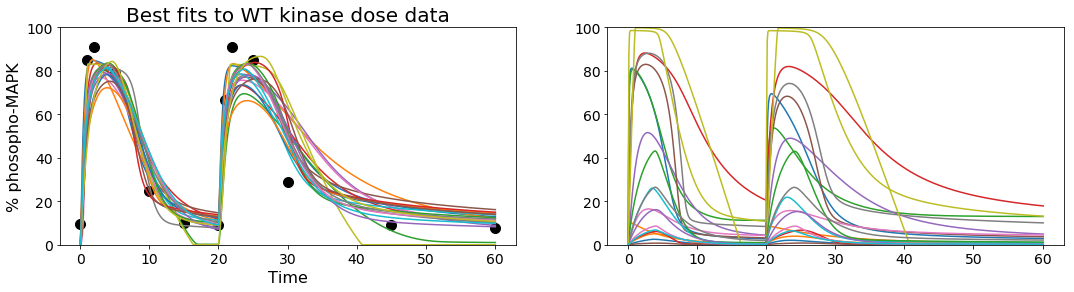

In [69]:
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t] 
plt_param_behaviors_ramp(hog1_ramp_data[0],gen,idx_top, 20, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

<Figure size 720x576 with 0 Axes>

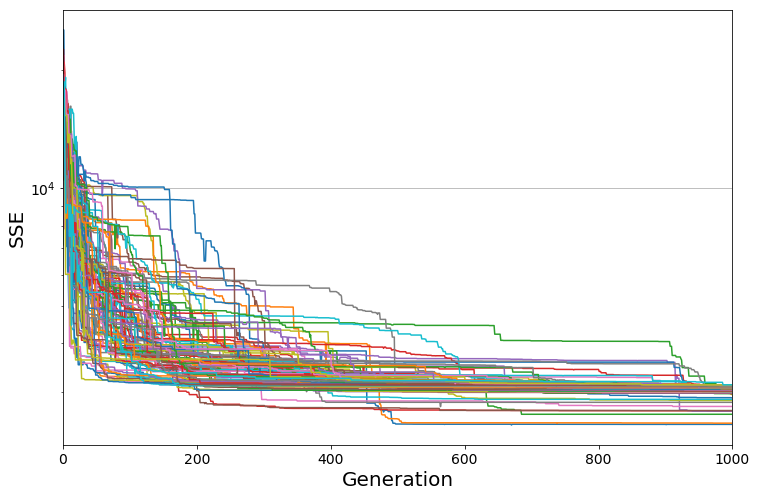

In [70]:
plt_mses_gen(gen,mse_aN_1D)

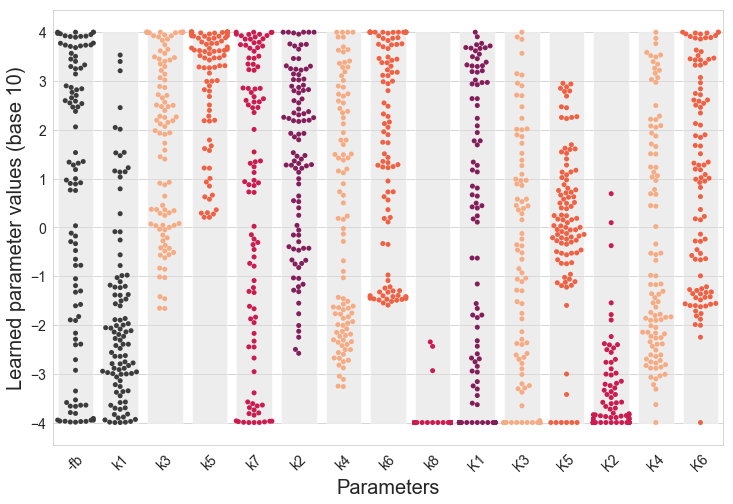

In [71]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


<Figure size 864x576 with 0 Axes>

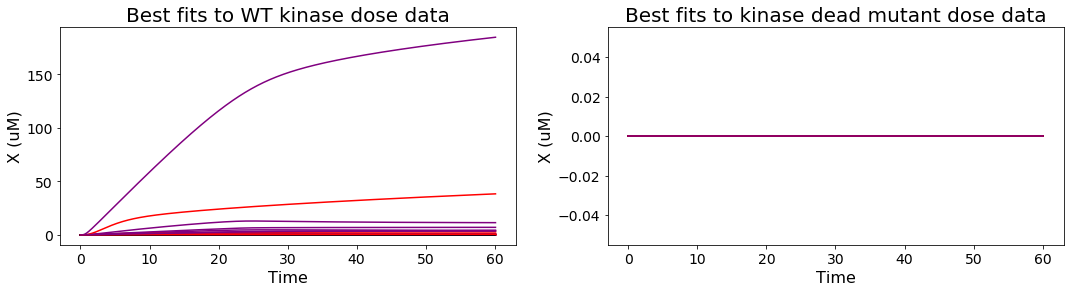

In [38]:
plt_X_behaviors(gen, idx_top, plt_top, params_from_file, 
                        params_constants_pulse, initals, time)

## A1

### Functions

In [105]:
def b3_a1_1D(initals,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = total_protein
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    # if signal_fxn:
    #     sig = signal_ramp_special(t)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def b3_a1_1D_ramp(initals,t,total_protein,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = total_protein
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    sig = signal_ramp_special(t)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

### Inputs

In [106]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/scripts_ramp_1/190225_a1_map2k_ramp/'
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190304_a1_map2k_ramp/'

run_name = 'b3_1D_a1'
gen = 1000
runs = 2000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+K',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-4, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 4, 4,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]

### Gather simulated data

In [107]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.05)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 1012.1489734117733
Mean MSE of top 5%: 1481.3212085341706


### Plot

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 720x576 with 0 Axes>

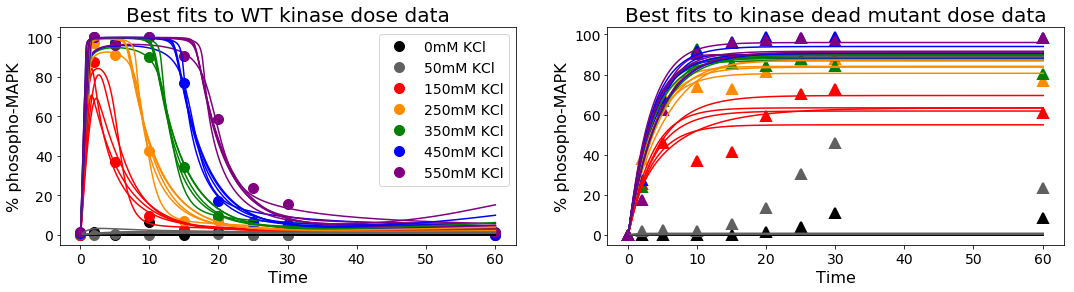

In [55]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


<Figure size 864x576 with 0 Axes>

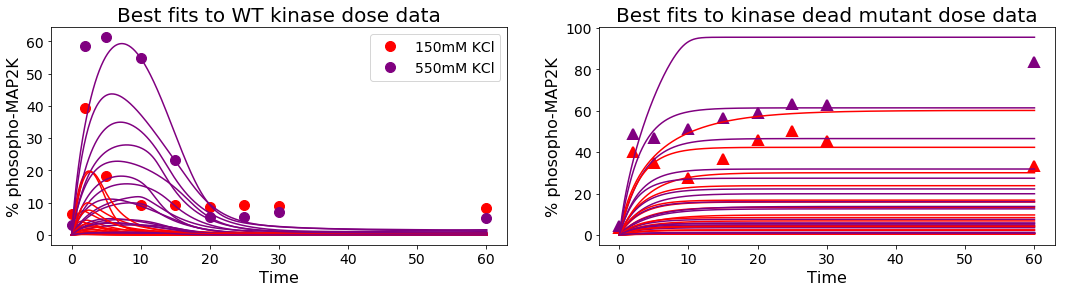

In [108]:
# map2k_s = [150000, 550000]
params_constants_map2k = [MAP3K_t, MAP2K_t, MAPK_t] 
plt_param_behaviors_map2k(map2k_wt_data, map2k_t100a_data, gen, idx_top, 20, params_from_file, 
                        params_constants_map2k,
                          initals, time)

<Figure size 864x576 with 0 Axes>

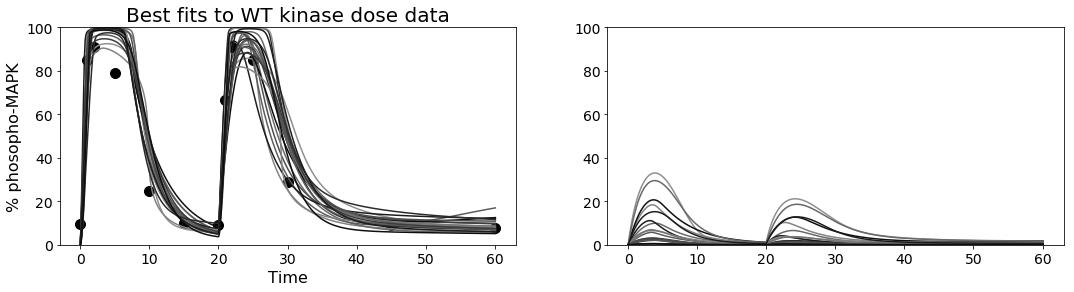

In [109]:
# pulse_s = [550000]
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t] 
plt_param_behaviors_ramp(hog1_ramp_data[0],gen,idx_top, 20, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

<Figure size 720x576 with 0 Axes>

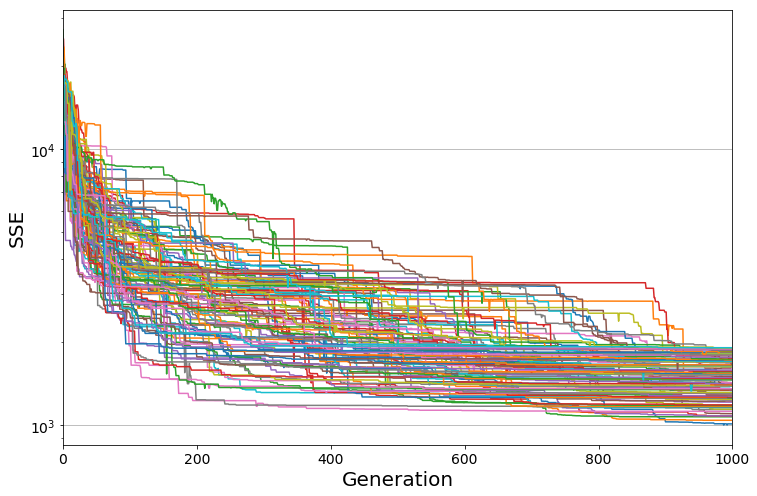

In [17]:
plt_mses_gen(gen,mse_a1_1D)

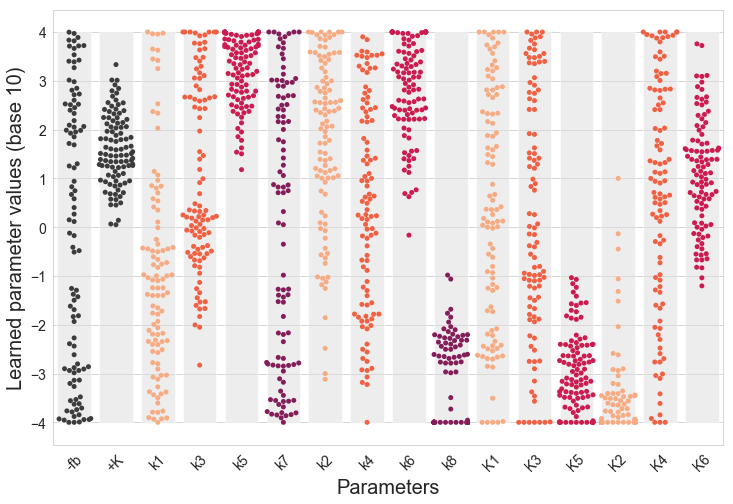

In [18]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

TypeError: simulate_wt_experiment() takes 5 positional arguments but 7 were given

<Figure size 864x576 with 0 Axes>

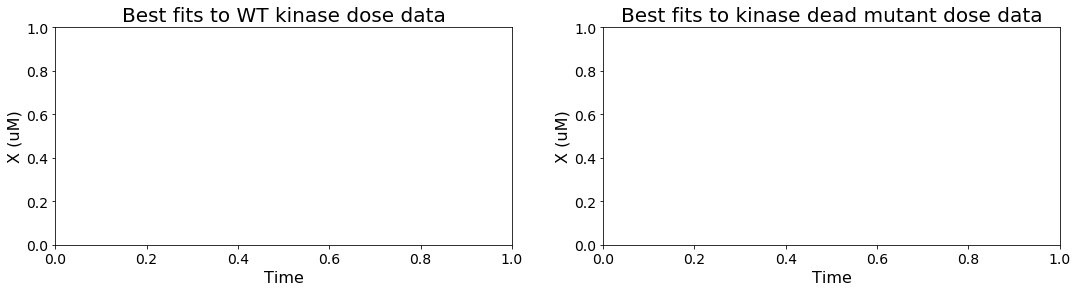

In [29]:
plt_X_behaviors(gen, idx_top, 5, params_from_file, 
                        params_constants_pulse, initals, time)

In [27]:
plt_X_behaviors_pulse(mapk_wt_data, map2k_wt_data, gen, idx_top, plt_top, params_from_file, params_constants, initals, time)

TypeError: plt_X_behaviors_pulse() takes 7 positional arguments but 9 were given

(array([ 81., 230., 831., 599., 137.,  41.,  35.,  32.,   8.,   4.,   0.,
          0.,   1.,   0.,   1.]),
 array([ 1489.37733187,  2293.43204884,  3097.4867658 ,  3901.54148277,
         4705.59619974,  5509.6509167 ,  6313.70563367,  7117.76035064,
         7921.81506761,  8725.86978457,  9529.92450154, 10333.97921851,
        11138.03393548, 11942.08865244, 12746.14336941, 13550.19808638]),
 <a list of 15 Patch objects>)

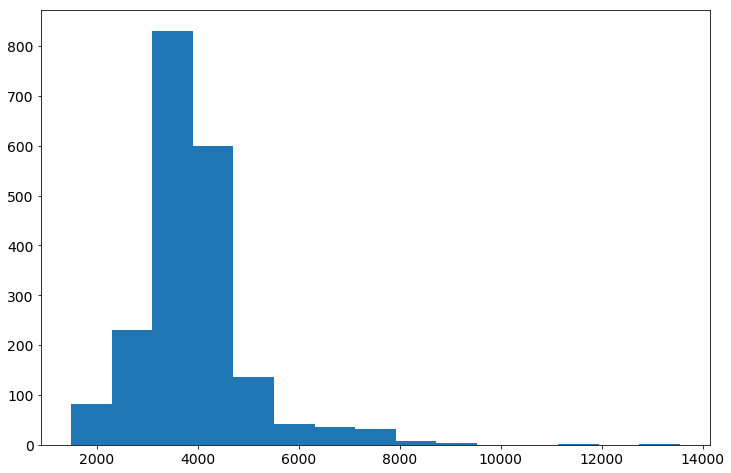

In [20]:
plt.hist(last_mses_a1_1D,bins=15,color='#1f77b4')

## A2

### Functions

In [116]:
def b3_a2_1D_X(initals,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = total_protein
    beta_3, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # Y_I = Y_t-Y
#     if signal_fxn:
#         sig = signal_fxn(t,sig,signal_params)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a2_1D_X, inits, time, args=(total_protein, sig, learned_params))

    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(b3_a2_1D_X, inits, time, args=(total_protein, sig, learned_params))

    return odes

def b3_a2_1D_ramp(initals,t,total_protein,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = total_protein
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    sig = signal_ramp_special(t)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha_1*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a2_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

### Inputs

In [118]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/1_pass/181025_b3_1D_a1/'
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190304_a2_map2k_ramp/'

run_name = 'b3_1D_a2'
gen = 1000
runs = 2000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+K',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-4, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 4, 4,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t] 

### Gather simulated data

In [113]:
idx_top, top_params_a2_1D, top, plt_top, new_params, params_from_file, mse_a2_1D, last_mses_a2_1D = gather_simulated_data(folder, gen, runs, 0.05)
df_top_params = pd.DataFrame(top_params_a2_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 1240.3668736101426
Mean MSE of top 5%: 2306.8218296095015


### Plot

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

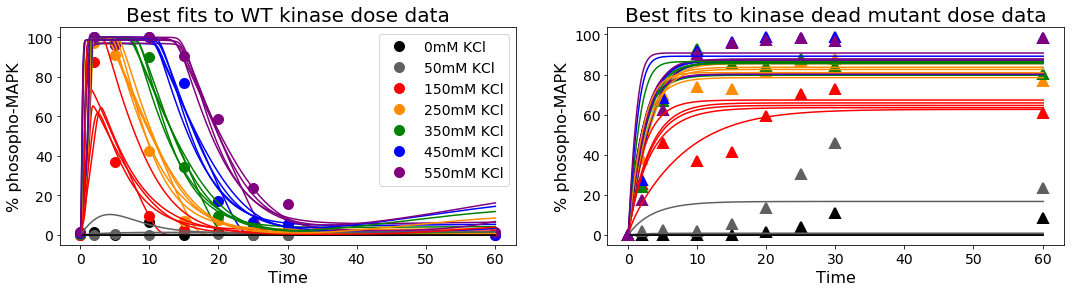

In [119]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

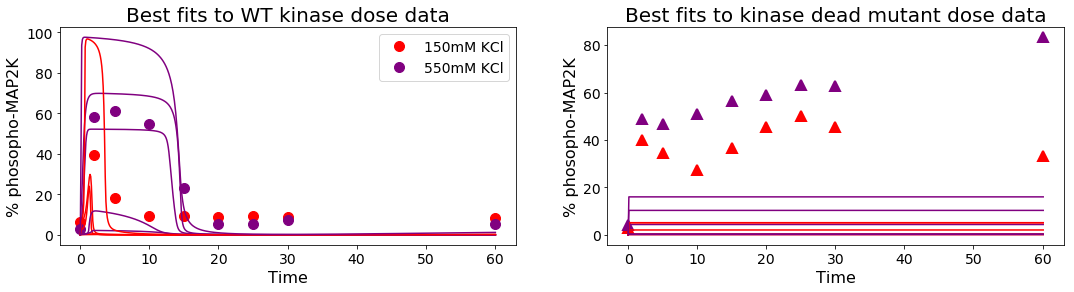

In [120]:
map2k_s = [150000, 550000]
params_constants_map2k = [MAP3K_t, MAP2K_t, MAPK_t] 
plt_param_behaviors_map2k(map2k_wt_data, map2k_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants_map2k, initals, time)

<Figure size 864x576 with 0 Axes>

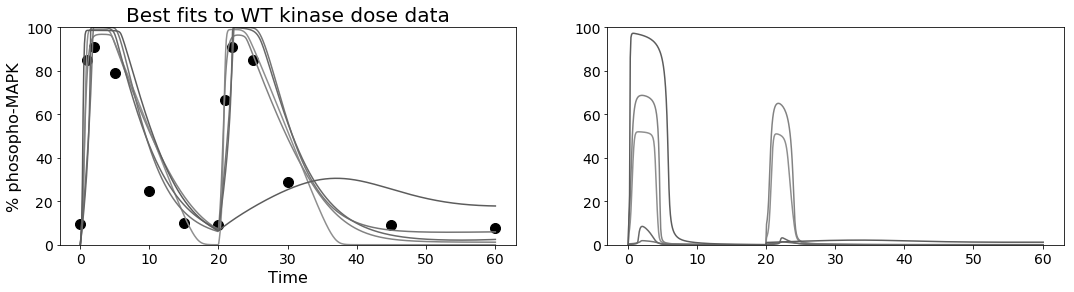

In [121]:
# pulse_s = [550000]
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t] 
plt_param_behaviors_ramp(hog1_ramp_data[0],gen,idx_top, 5, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

<Figure size 864x576 with 0 Axes>

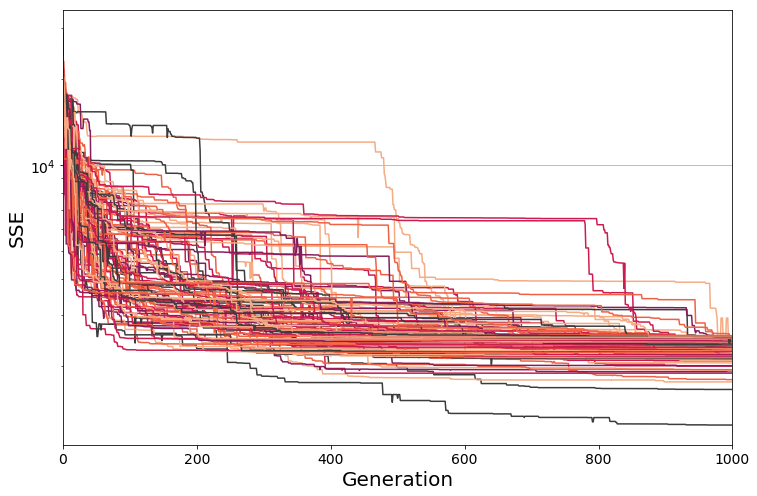

In [26]:
plt_mses_gen(gen,mse_a2_1D)

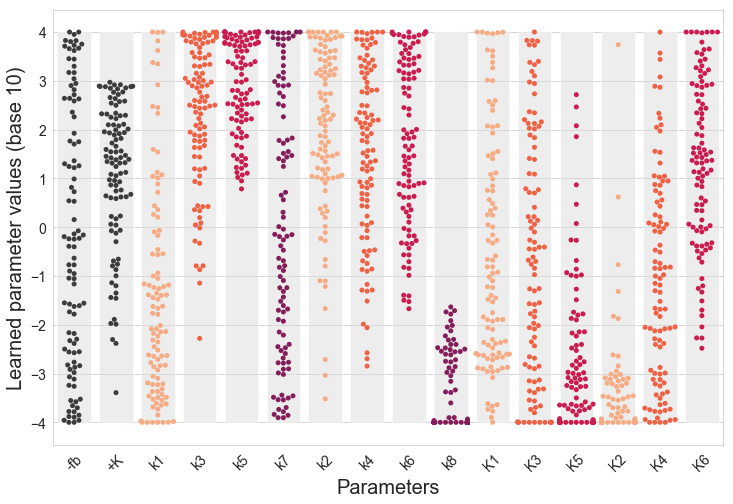

In [27]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

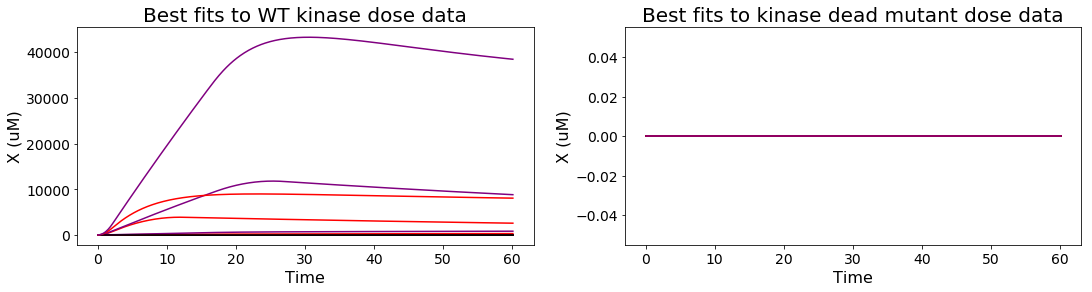

In [36]:
plt_X_behaviors(gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

(array([  41.,  307., 1046.,  324.,  116.,   31.,   46.,   43.,   10.,
           4.,    0.,   13.,    7.,    8.,    3.]),
 array([ 1918.0261265 ,  2719.18135245,  3520.3365784 ,  4321.49180434,
         5122.64703029,  5923.80225624,  6724.95748218,  7526.11270813,
         8327.26793408,  9128.42316002,  9929.57838597, 10730.73361192,
        11531.88883786, 12333.04406381, 13134.19928976, 13935.3545157 ]),
 <a list of 15 Patch objects>)

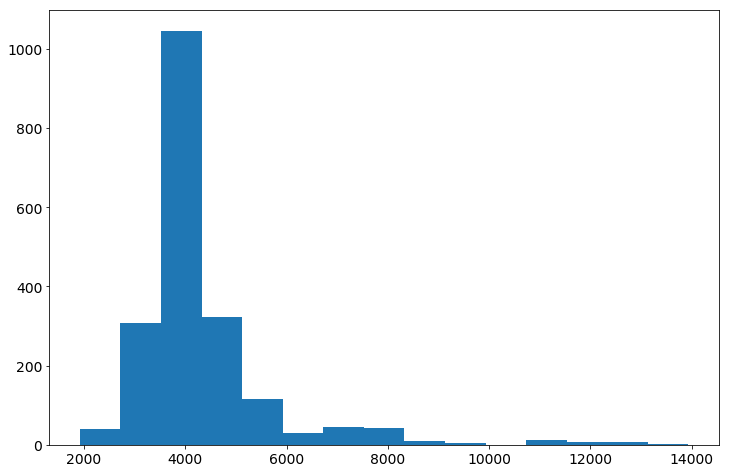

In [29]:
plt.hist(last_mses_a2_1D,bins=15,color='#1f77b4')

## A3

### Functions

In [99]:
def b3_a3_1D_X(initals,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = total_protein
    beta_3, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # Y_I = Y_t-Y
#     if signal_fxn:
#         sig = signal_fxn(t,sig,signal_params)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1+alpha*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a3_1D_X, inits, time, args=(total_protein, sig, learned_params))

    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(b3_a3_1D_X, inits, time, args=(total_protein, sig, learned_params))

    return odes


def b3_a3_1D_ramp(initals,t,total_protein,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = total_protein
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    sig = signal_ramp_special(t)

    dMAP3K = (sig/(1+X/beta_3)) * (((k1+alpha_1*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a3_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

### Inputs

In [82]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/1_pass/181025_b3_1D_a1/'
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190304_a3_map2k_ramp/'

run_name = 'b3_1D_a2'
gen = 1000
runs = 2000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+K',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-4, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 4, 4,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t] 

### Gather simulated data

In [83]:
idx_top, top_params_a3_1D, top, plt_top, new_params, params_from_file, mse_a3_1D, last_mses_a3_1D = gather_simulated_data(folder, gen, runs, 0.05)
df_top_params = pd.DataFrame(top_params_a3_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 1406.5398648501111
Mean MSE of top 5%: 2372.7511894879253


### Plot

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

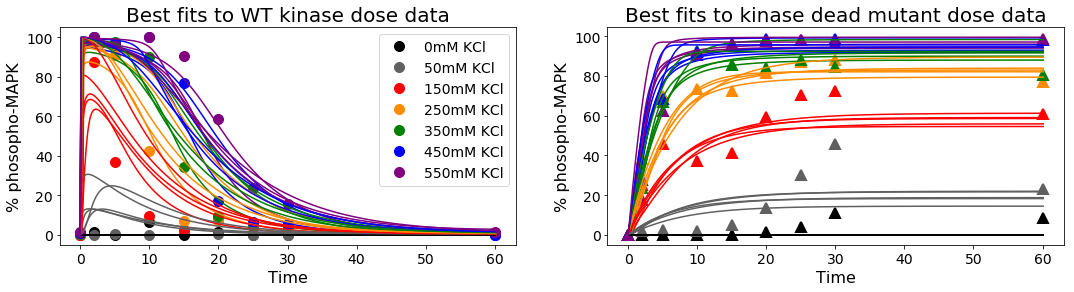

In [95]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

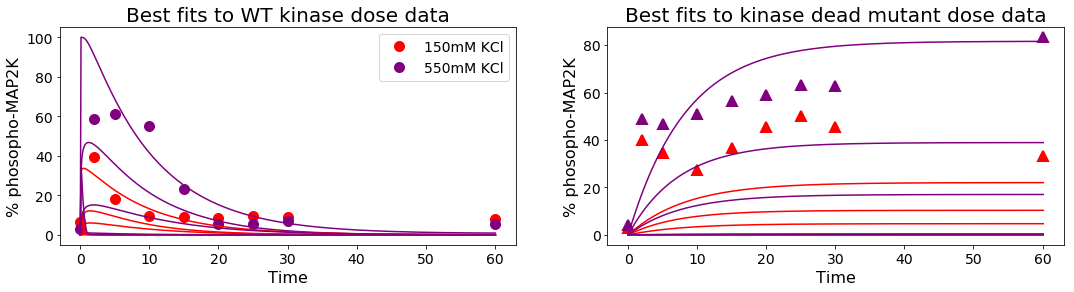

In [96]:
map2k_s = [150000, 550000]
params_constants_map2k = [MAP3K_t, MAP2K_t, MAPK_t] 
plt_param_behaviors_map2k(map2k_wt_data, map2k_t100a_data, gen, idx_top, 5, params_from_file, 
                        params_constants_map2k, initals, time)

<Figure size 864x576 with 0 Axes>

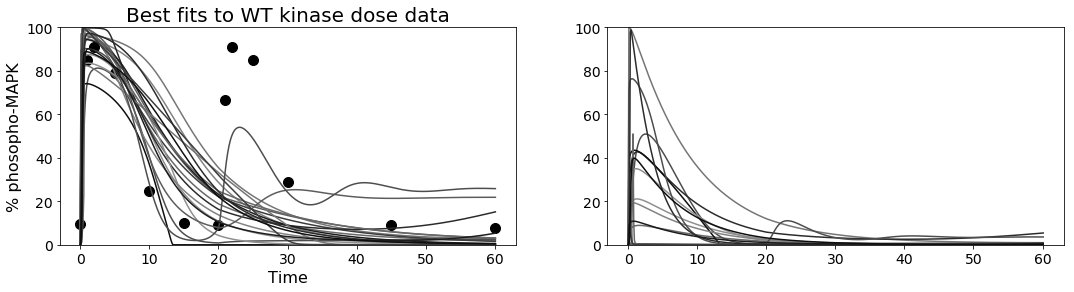

In [102]:
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t] 
plt_param_behaviors_ramp(hog1_ramp_data[0],gen,idx_top, 20, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

<Figure size 864x576 with 0 Axes>

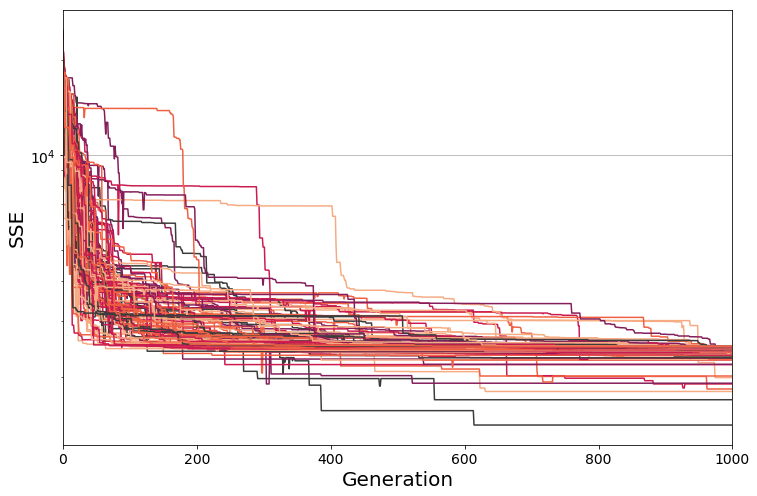

In [98]:
plt_mses_gen(gen,mse_a3_1D)

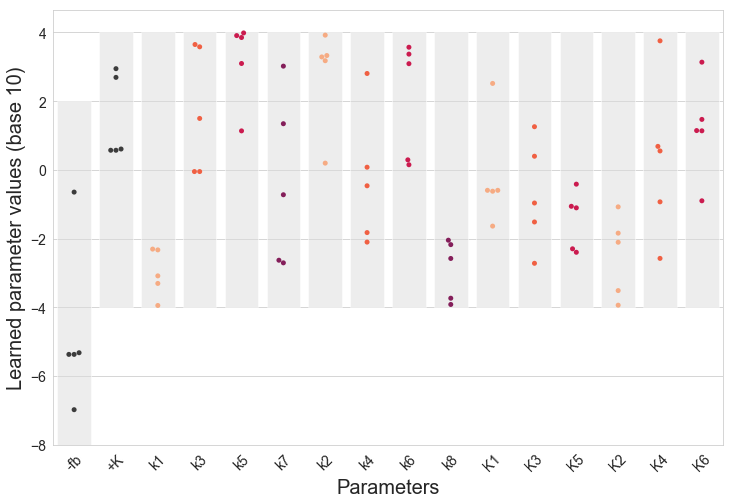

In [93]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

# of unstable WT experiments: 0 of 30
# of unstable T100A experiments: 0 of 30


<Figure size 864x576 with 0 Axes>

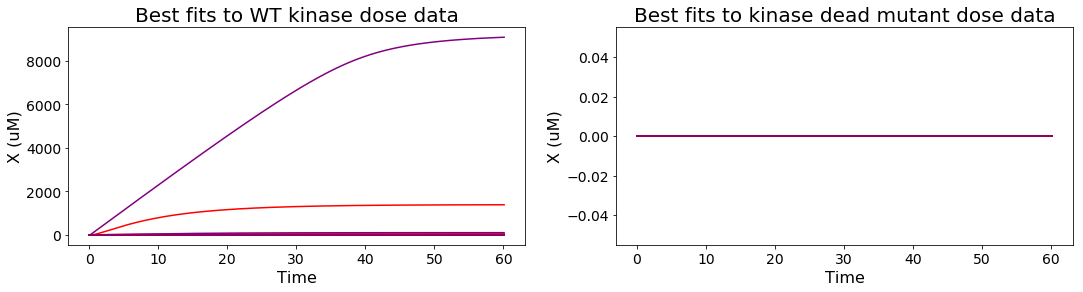

In [100]:
plt_X_behaviors(gen, idx_top, 5, params_from_file, 
                        params_constants, initals, time)

# Predictions

## Change Signal



In [ ]:
def signal_periodic(t_step, signal, period):
    if t_step == 0:
        s = 0
    elif t_step >= 60:
        s = 0
    elif t_step >= 30:
        s = 0
    elif np.floor(t_step / period) % 2 == 0:
        s =  signal
    else:
        s = 0
#     signal = 
#     print(len_period)
    return s
# [signal_periodic(x, 55000, 20) for x in time]

plt.plot(time, [signal_periodic(x, 55000, 10) for x in time])

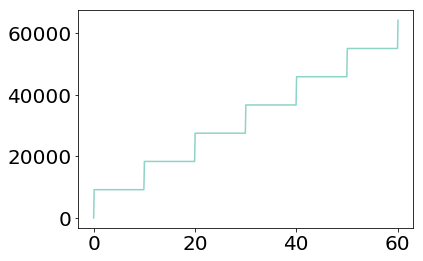

In [115]:
def signal_ramp(t_step, signal_end, step_len):
    num_steps = 60 / step_len
    cut_off = np.ceil(t_step/step_len)
    step = signal_end/num_steps
    return step*cut_off
plt.plot(time,[signal_ramp(x, 55000, 10) for x in time])

## Functions

In [113]:
def b3_aN_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    s = signal_fxn(t,fxn_params[1],fxn_params[2])

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a1_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    s = signal_fxn(t,fxn_params[1],fxn_params[2])

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a2_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_2, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    s = signal_fxn(t,fxn_params[1],fxn_params[2])

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha_2*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a3_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    s = signal_fxn(t,fxn_params[1],fxn_params[2])

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1+alpha_3*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = (s7*MAPK) - (d8*X)

    return dMAP3K, dMAP2K, dMAPK, dX

<Figure size 432x288 with 0 Axes>

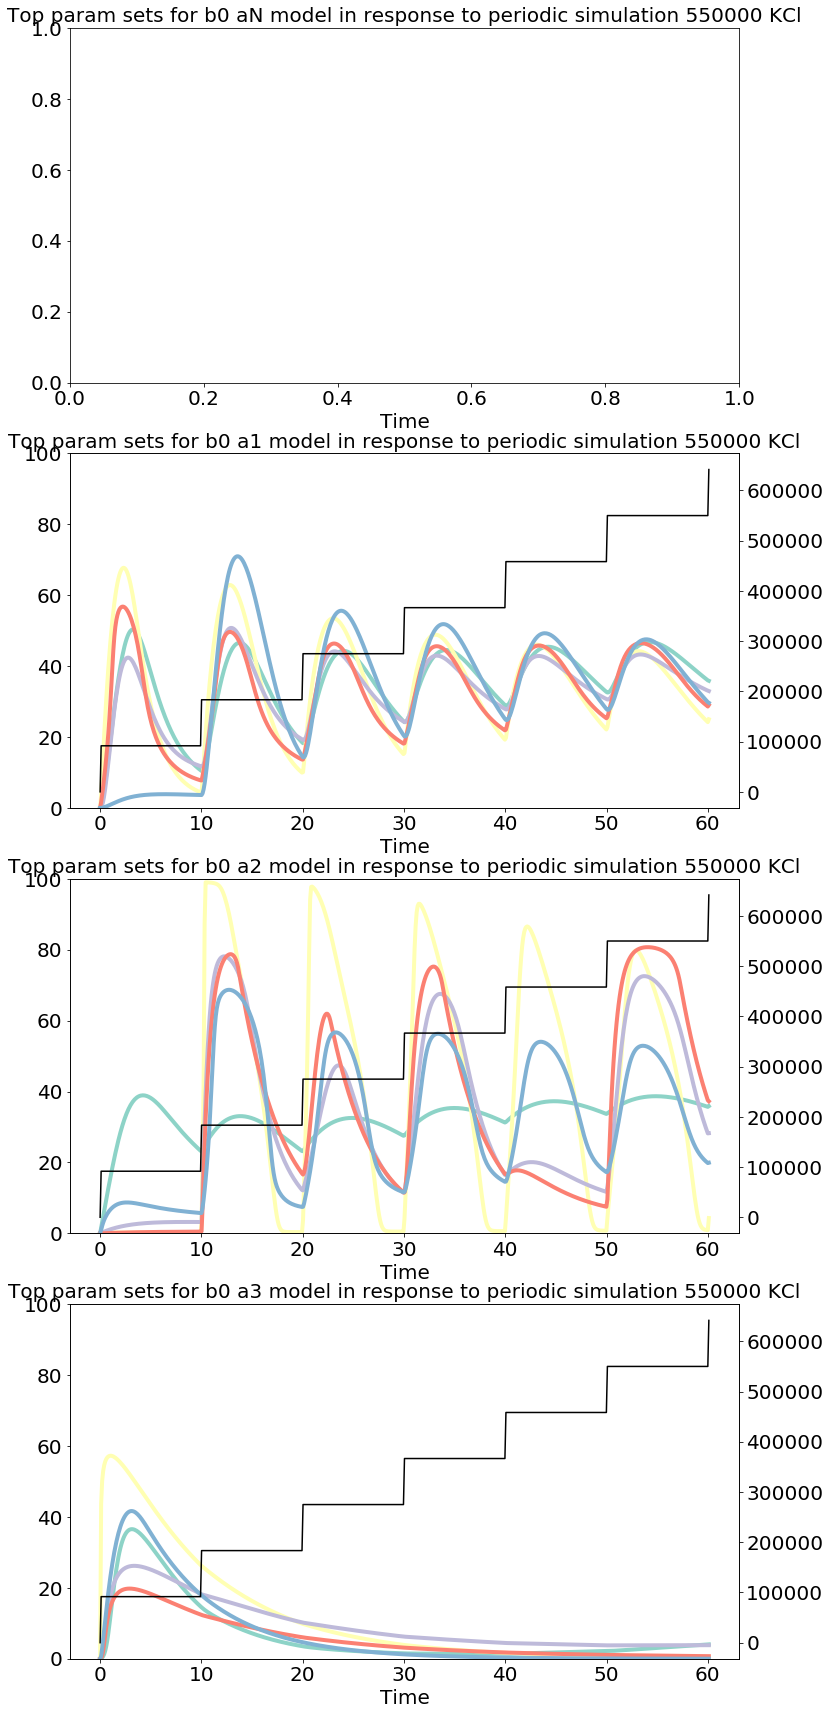

In [140]:
len_step_min = 10
signal = 550000
num_predict = 5

#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12,30))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t]

colors = sns.color_palette("Set3", 20)
sns.set_palette(colors)

#plot 1
title_text = 'Top param sets for b0 aN model in response to periodic simulation '+str(signal)+' KCl'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)

# for idx, param_set in enumerate(top_params_aN_1D[:num_predict]):
#     data = odeint(b3_aN_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp,[_, signal, len_step_min]))
#     ax1.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
# ax1.set_ylim(0,100)
# ax1b = ax1.twinx()
# ax1b.plot(time,[signal_ramp(x, signal, len_step_min) for x in time], color='black')
# ax1.legend()
    
    
#plot2
title_text = 'Top param sets for b0 a1 model in response to periodic simulation '+str(signal)+' KCl'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, param_set in enumerate(top_params_a1_1D[:num_predict]):
    data = odeint(b3_a1_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp,[_, signal, len_step_min]))
    ax2.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax2.set_ylim(0,100)
ax2b = ax2.twinx()
ax2b.plot(time,[signal_ramp(x, signal, len_step_min) for x in time], color='black')
# ax2.legend()


#plot 3
title_text = 'Top param sets for b0 a2 model in response to periodic simulation '+str(signal)+' KCl'
ax3.set_title(title_text, fontsize=20)
ax3.set_xlabel('Time', fontsize=20)


for idx, param_set in enumerate(top_params_a2_1D[:num_predict]):
    data = odeint(b3_a2_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp,[_, signal, len_step_min]))
    ax3.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax3.set_ylim(0,100)
ax3b = ax3.twinx()
ax3b.plot(time,[signal_ramp(x, signal, len_step_min) for x in time], color='black')

#plot 4
title_text = 'Top param sets for b0 a3 model in response to periodic simulation '+str(signal)+' KCl'
ax4.set_title(title_text, fontsize=20)
ax4.set_xlabel('Time', fontsize=20)

# initals = [MAP3K, MAP2K, MAPK, X, Y]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t]

for idx, param_set in enumerate(top_params_a3_1D[:num_predict]):
    data = odeint(b3_a3_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp,[_, signal, len_step_min]))
    ax4.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax4.set_ylim(0,100)
ax4b = ax4.twinx()
ax4b.plot(time,[signal_ramp(x, signal, len_step_min) for x in time], color='black')

# ax3.legend()
plt.show()

In [147]:
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 15:
        sig = 550000
    return sig
def b3_aN_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    if fxn_params:
        s = signal_fxn(t,fxn_params[1],fxn_params[2])
    else:
        s = signal_fxn(t)
        
    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a1_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_1, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    if fxn_params:
        s = signal_fxn(t,fxn_params[1],fxn_params[2])
    else:
        s = signal_fxn(t)

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a2_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_2, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    if fxn_params:
        s = signal_fxn(t,fxn_params[1],fxn_params[2])
    else:
        s = signal_fxn(t)

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha_2*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def b3_a3_1D_predict(initals,t,params_constants,params, signal_fxn, fxn_params=None):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t = params_constants
    beta_3, alpha_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params
    
    if fxn_params:
        s = signal_fxn(t,fxn_params[1],fxn_params[2])
    else:
        s = signal_fxn(t)

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+X/beta_3)) * (((k1+alpha_3*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = (s7*MAPK) - (d8*X)

    return dMAP3K, dMAP2K, dMAPK, dX

<Figure size 432x288 with 0 Axes>

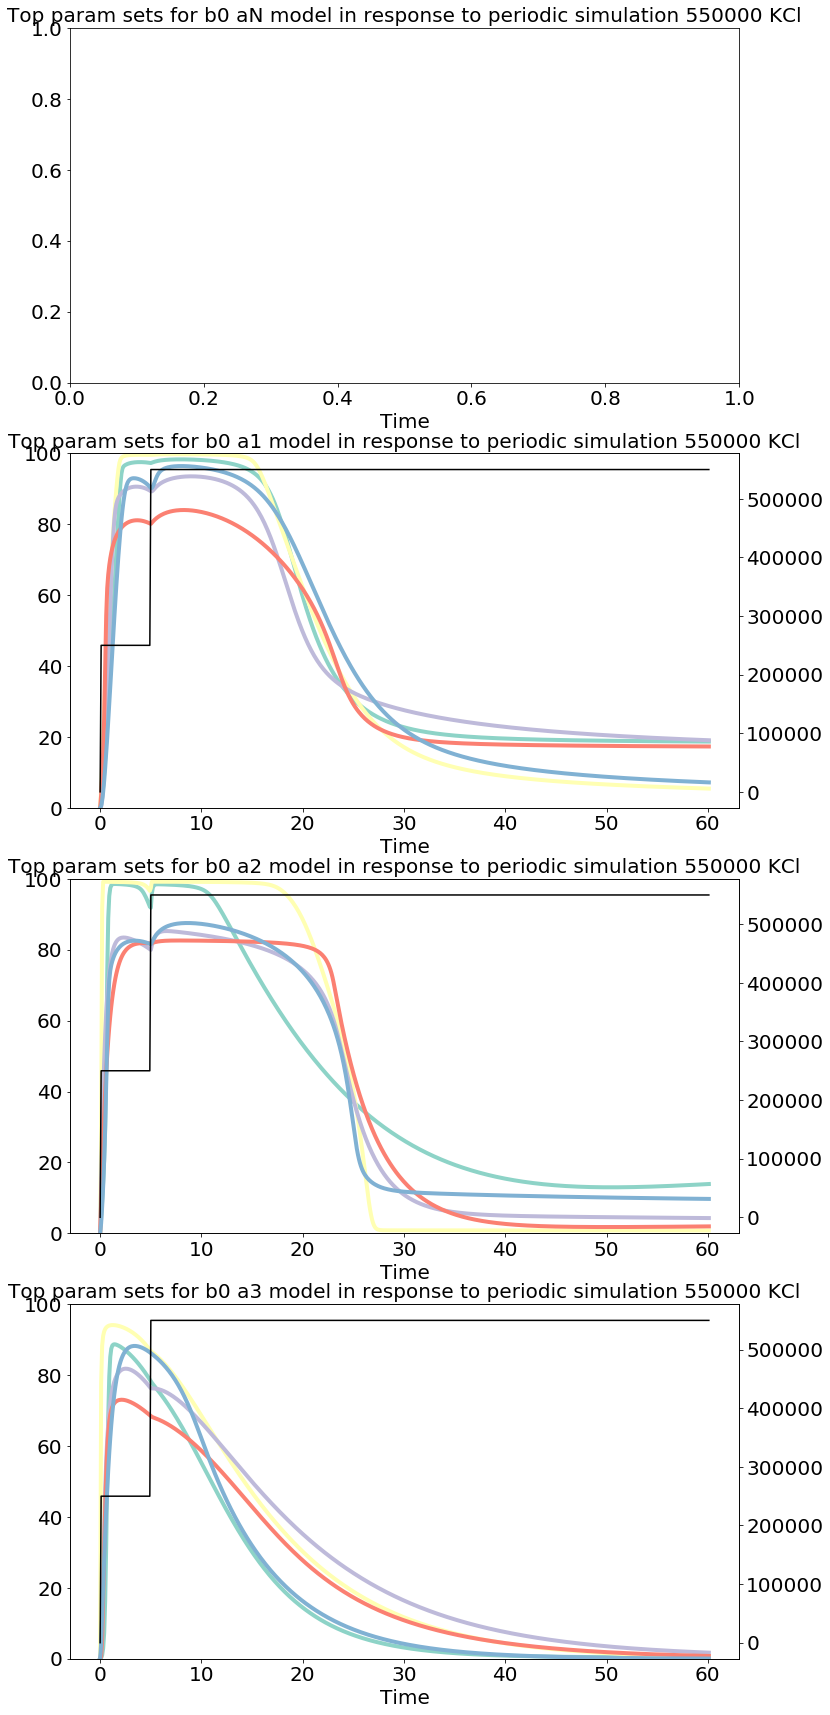

In [153]:


# len_step_min = 10
# signal = 550000
# num_predict = 10
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 5:
        sig = 550000
    return sig
plt.plot(time,[signal_ramp_special(x) for x in time])


num_predict=5

#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12,30))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t]

colors = sns.color_palette("Set3", 20)
sns.set_palette(colors)

#plot 1
title_text = 'Top param sets for b0 aN model in response to periodic simulation '+str(signal)+' KCl'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)

# for idx, param_set in enumerate(top_params_aN_1D[:num_predict]):
#     data = odeint(b3_aN_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp_special))
#     ax1.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
# ax1.set_ylim(0,100)
# ax1b = ax1.twinx()
# ax1b.plot(time,[signal_ramp_special(x) for x in time], color='black')
# # ax1.legend()
    
    
#plot2
title_text = 'Top param sets for b0 a1 model in response to periodic simulation '+str(signal)+' KCl'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, param_set in enumerate(top_params_a1_1D[:num_predict]):
    data = odeint(b3_a1_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp_special))
    ax2.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax2.set_ylim(0,100)
ax2b = ax2.twinx()
ax2b.plot(time,[signal_ramp_special(x) for x in time], color='black')
# ax2.legend()


#plot 3
title_text = 'Top param sets for b0 a2 model in response to periodic simulation '+str(signal)+' KCl'
ax3.set_title(title_text, fontsize=20)
ax3.set_xlabel('Time', fontsize=20)


for idx, param_set in enumerate(top_params_a2_1D[:num_predict]):#:num_predict]):
    data = odeint(b3_a2_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp_special))
    ax3.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax3.set_ylim(0,100)
ax3b = ax3.twinx()
ax3b.plot(time,[signal_ramp_special(x) for x in time], color='black')

#plot 4
title_text = 'Top param sets for b0 a3 model in response to periodic simulation '+str(signal)+' KCl'
ax4.set_title(title_text, fontsize=20)
ax4.set_xlabel('Time', fontsize=20)

# initals = [MAP3K, MAP2K, MAPK, X, Y]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t]

for idx, param_set in enumerate(top_params_a3_1D[:num_predict]):
    data = odeint(b3_a3_1D_predict, initals, time, args=(params_constants, param_set,signal_ramp_special))
    ax4.plot(time,data[:,2]/params_constants[2]*100,label=str(idx),linewidth=4)
    
ax4.set_ylim(0,100)
ax4b = ax4.twinx()
ax4b.plot(time,[signal_ramp_special(x) for x in time], color='black')

# ax3.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

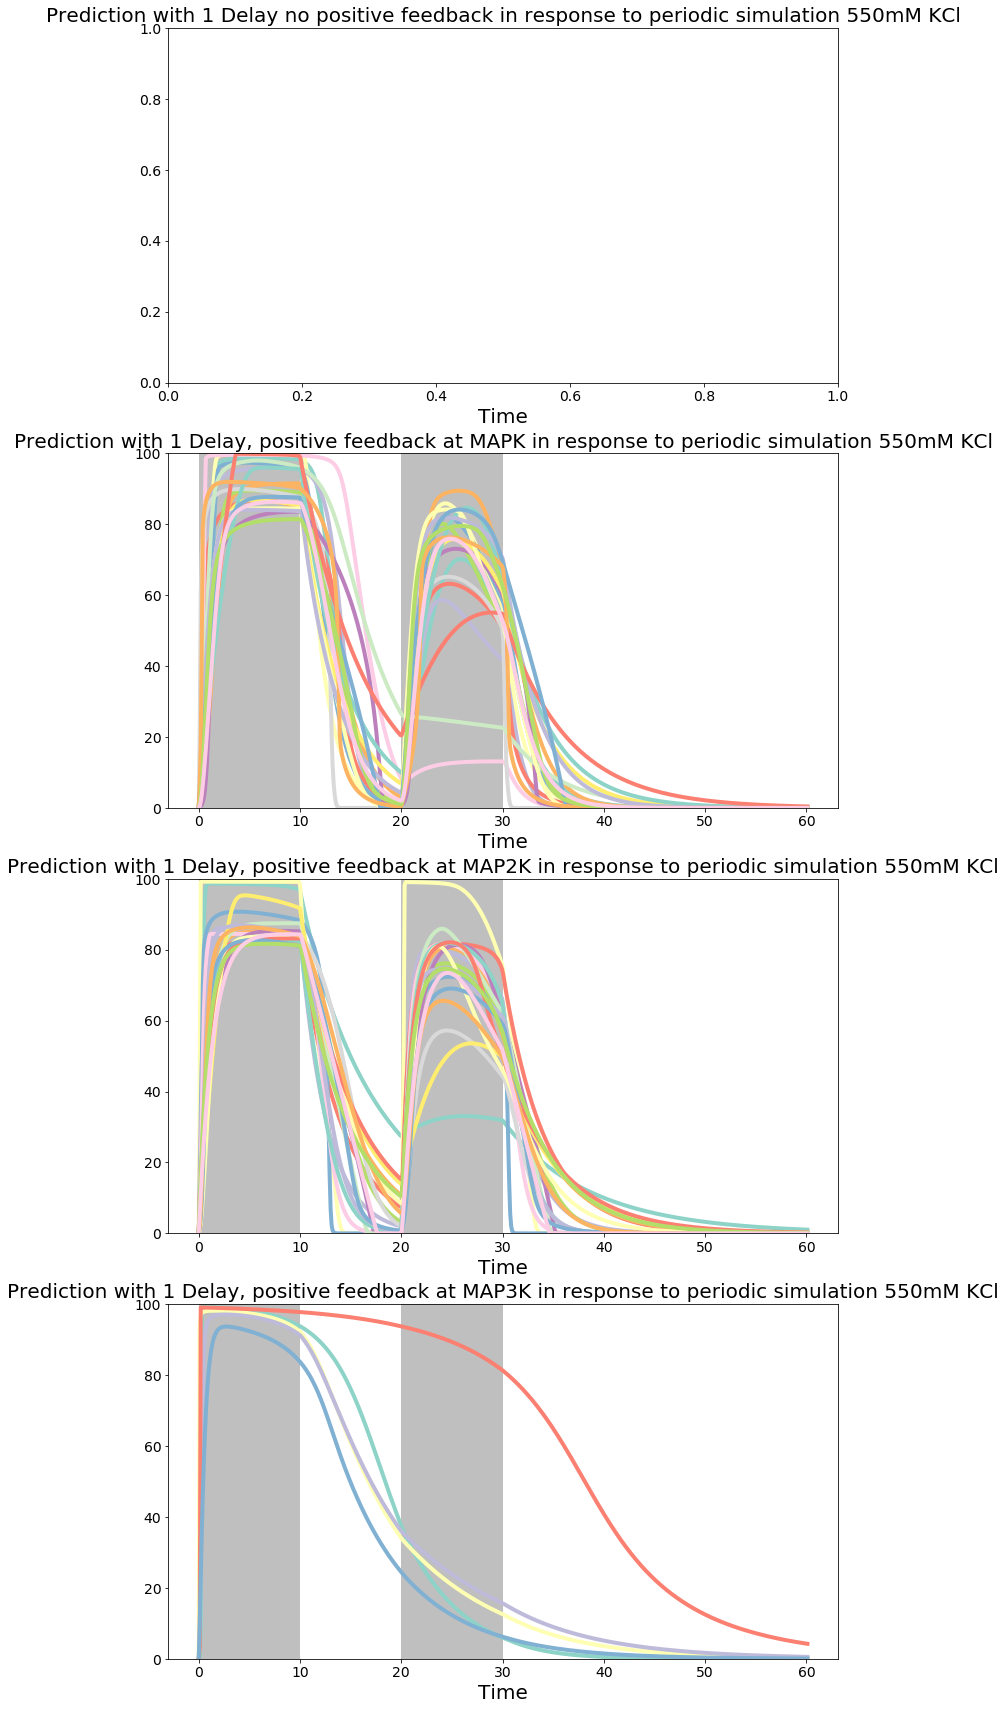

In [139]:
len_period_min = 10
signal = 550000
pulse_strain = 2

colors = sns.color_palette("Set3", 20)
sns.set_palette(colors)

#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12,30))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t]


#plot 1
title_text = 'Prediction with 1 Delay no positive feedback in response to periodic simulation 550mM KCl'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)

# for idx, param_set in enumerate(top_params_aN_1D[:20]):
#     data = odeint(b3_aN_1D_predict, initals, time, args=(params_constants, param_set,signal_periodic,[_, signal, len_period_min]))
#     ax1.plot(time,data[:,pulse_strain]/params_constants[pulse_strain]*100,label=str(idx),linewidth=4)
    
# ax1.set_ylim(0,100)
# for x in range(0,30,len_period_min*2):
#     ax1.fill_between([x,x+len_period_min], 0, 550, facecolor='gray', alpha=0.5)
    
    
#plot2
title_text = 'Prediction with 1 Delay, positive feedback at MAPK in response to periodic simulation 550mM KCl'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, param_set in enumerate(top_params_a1_1D[:20]):
    data = odeint(b3_a1_1D_predict, initals, time, args=(params_constants, param_set,signal_periodic,[_, signal, len_period_min]))
    ax2.plot(time,data[:,pulse_strain]/params_constants[pulse_strain]*100,label=str(idx),linewidth=4)
    
ax2.set_ylim(0,100)
for x in range(0,30,len_period_min*2):
    ax2.fill_between([x,x+len_period_min], 0, 550, facecolor='gray', alpha=0.5)


#plot 3
title_text = 'Prediction with 1 Delay, positive feedback at MAP2K in response to periodic simulation 550mM KCl'
ax3.set_title(title_text, fontsize=20)
ax3.set_xlabel('Time', fontsize=20)


for idx, param_set in enumerate(top_params_a2_1D[:20]):
    data = odeint(b3_a2_1D_predict, initals, time, args=(params_constants, param_set,signal_periodic,[_, signal, len_period_min]))
    ax3.plot(time,data[:,pulse_strain]/params_constants[pulse_strain]*100,label=str(idx),linewidth=4)
    
ax3.set_ylim(0,100)
for x in range(0,30,len_period_min*2):
    ax3.fill_between([x,x+len_period_min], 0, 550, facecolor='gray', alpha=0.5)

#plot 4
title_text = 'Prediction with 1 Delay, positive feedback at MAP3K in response to periodic simulation 550mM KCl'
ax4.set_title(title_text, fontsize=20)
ax4.set_xlabel('Time', fontsize=20)

# initals = [MAP3K, MAP2K, MAPK, X, Y]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t]

for idx, param_set in enumerate(top_params_a3_1D[:20]):
    data = odeint(b3_a3_1D_predict, initals, time, args=(params_constants, param_set,signal_periodic,[_, signal, len_period_min]))
    ax4.plot(time,data[:,pulse_strain]/params_constants[pulse_strain]*100,label=str(idx),linewidth=4)
    
ax4.set_ylim(0,100)
for x in range(0,30,len_period_min*2):
    ax4.fill_between([x,x+len_period_min], 0, 550, facecolor='gray', alpha=0.5)
# ax3.legend()
plt.show()

In [ ]:
# Colormap D is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, 
# BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, 
# PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, 
# PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, 
# Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, 
# YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, 
# cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, 
# gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, 
# gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, 
# icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink,
# pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, 
# summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

# Plot MSE vs. % of top fits

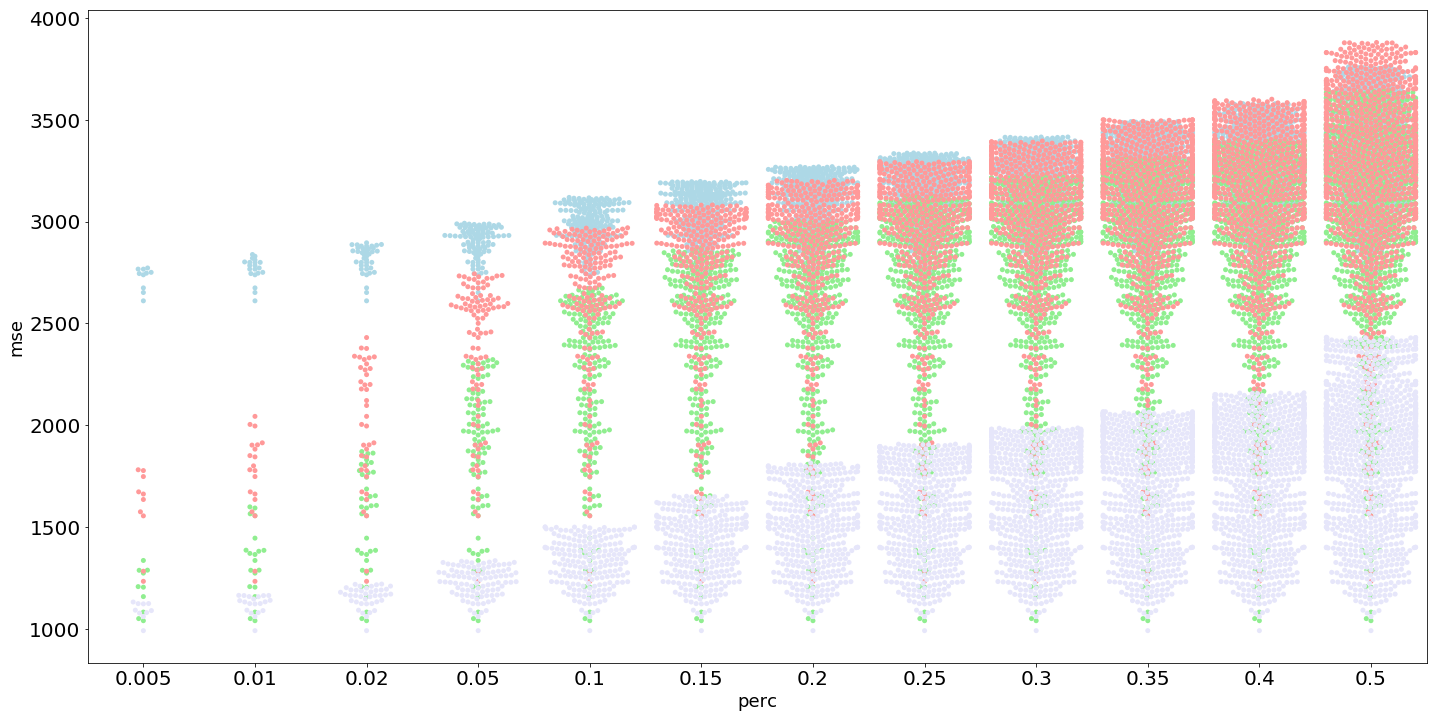

In [223]:
# mses_aN_1D_df = 

# percs = []
def get_mse_df(mses):
    sorted_mses = np.sort(mses)
    df = {'perc':[],'mse':[]}
    for p in [0.5,1,2,5,10,15,20,25,30,35,40,50]:
        perc = p/100
    #     percs.append(perc)
        top = round(perc*len(sorted_mses))
    #     df_ = {'perc': np.repeat(perc,top), 'mse': sorted_mses[:top]}
        df['perc'].append(np.repeat(perc,top))
        df['mse'].append(sorted_mses[:top])
    perc = np.concatenate(df['perc'],axis=0)
    mse = [x for y in df['mse'] for x in y]
    df = {'perc': perc,'mse':mse}
    df = pd.DataFrame(df)
    return df

mses_aN_1D_df = get_mse_df(last_mses_aN_1D)
mses_a1_1D_df = get_mse_df(last_mses_a1_1D)
mses_a2_1D_df = get_mse_df(last_mses_a2_1D)
mses_a3_1D_df = get_mse_df(last_mses_a3_1D)
# df.head()
# fig, ax = sns.subplots()
sns.swarmplot(x='perc',y='mse', data = mses_aN_1D_df, color='lightblue')
sns.swarmplot(x='perc',y='mse', data = mses_a1_1D_df, color='lightgreen')
sns.swarmplot(x='perc',y='mse', data = mses_a2_1D_df, color='#ff9999')
sns.swarmplot(x='perc',y='mse', data = mses_a3_1D_df, color='#E6E6FA')


# Plot all MSEs

In [52]:
# last_mses_a1_1D_branch
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_a1_1D_branch, last_mses_a2_1D_branch, last_mses_a3_1D_branch, last_mses_a3s_1D_branch]        
plot_mses(['+MAPK', '+MAP2K', '+MAP3K', '+MAP3Ks'], mses, 0.5, colors, '0D')

NameError: name 'last_mses_a1_1D_branch' is not defined

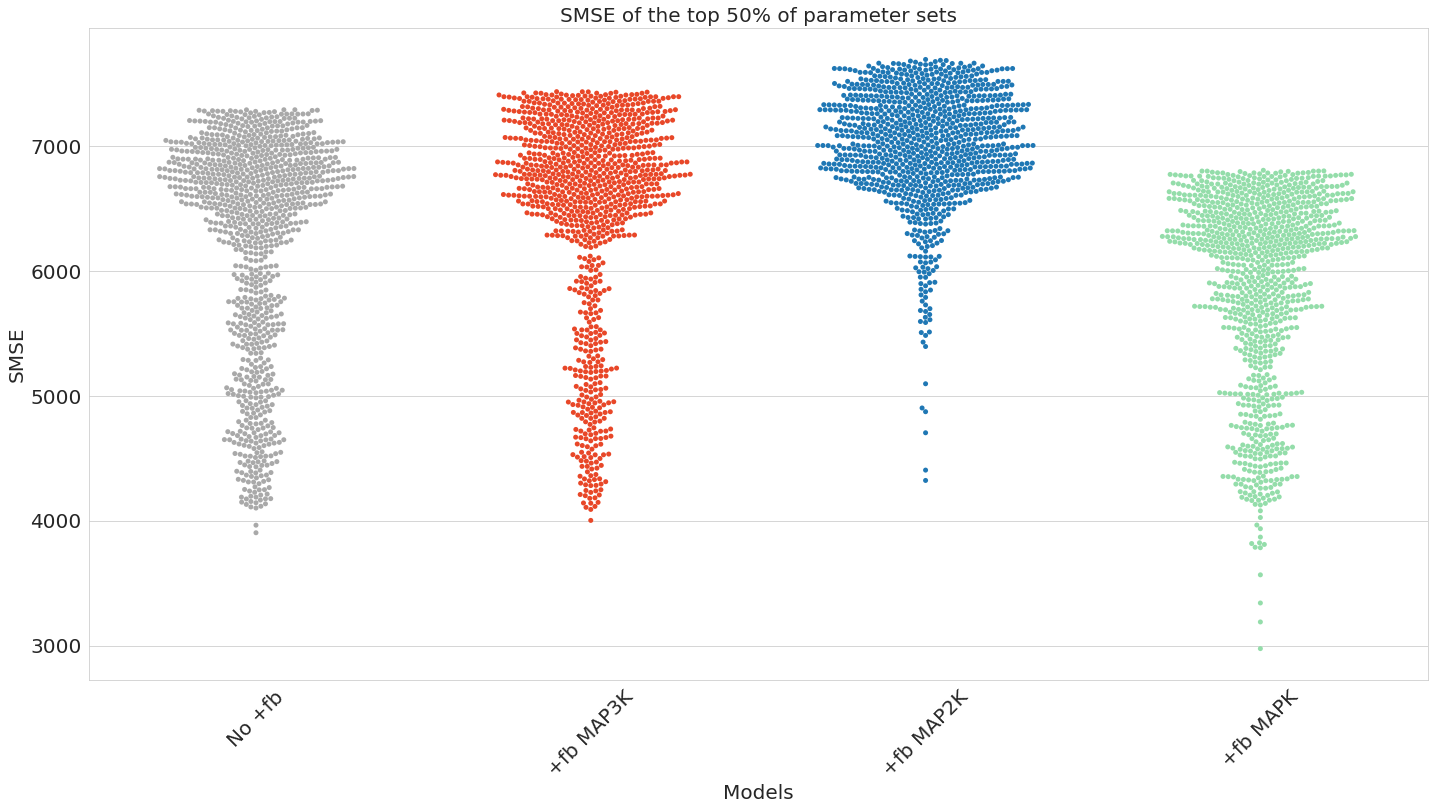

In [241]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_aN_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '0D')

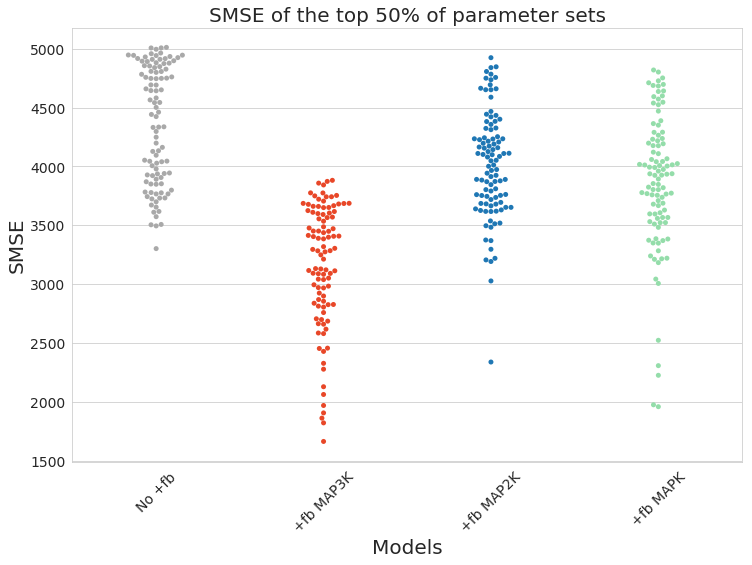

In [70]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_aN_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '1D')

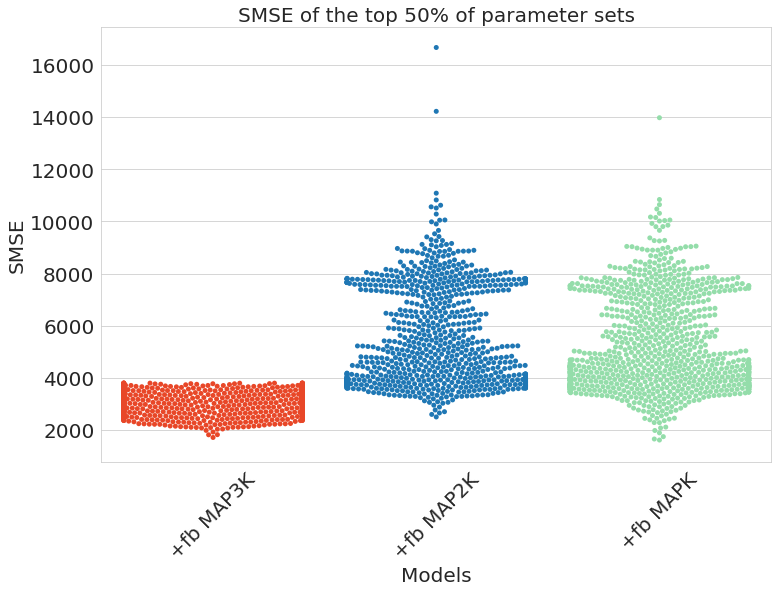

In [147]:
colors = ['#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '1D')

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

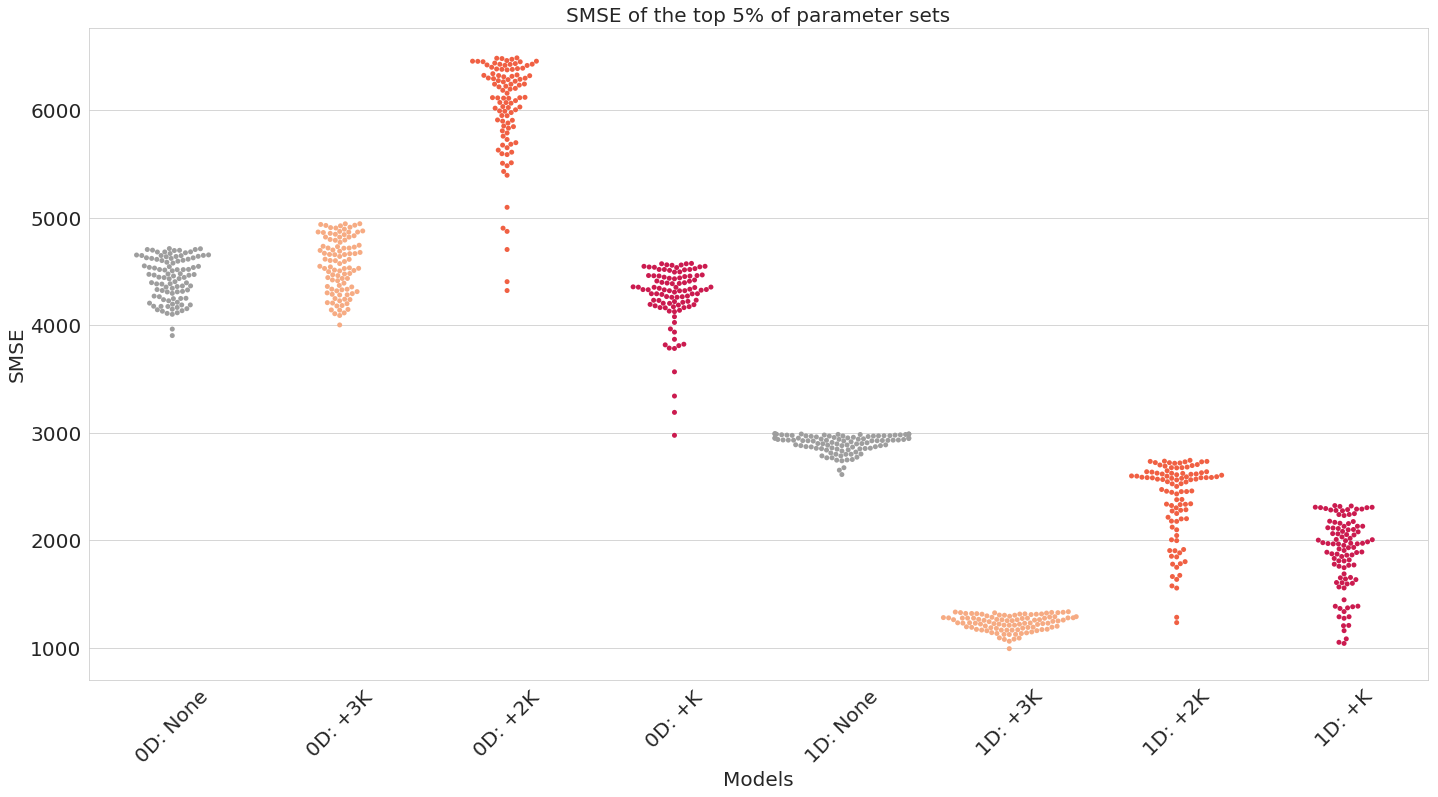

In [239]:
plt.rcParams['figure.figsize'] = [24.0, 12.0]
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [last_mses_aN_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D, 
        last_mses_aN_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D] 
#         last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['0D: None', '0D: +3K', '0D: +2K', '0D: +K',
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K'],
#            '2D: None', '2D: +3K', '2D: +2K', '2D: +K'],
          mses, 0.05, colors,'mses_all')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mses_all.png",dpi=300)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


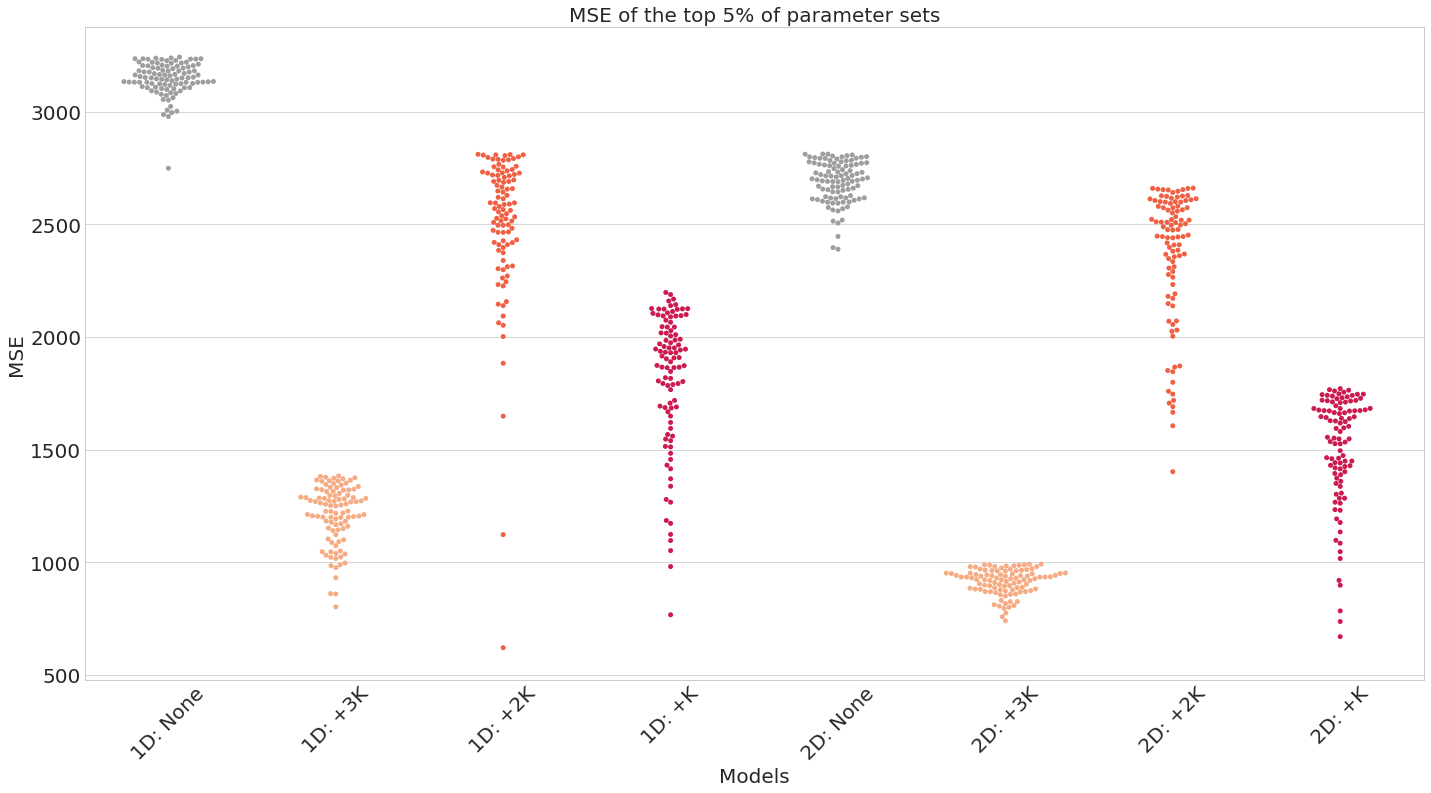

In [132]:
# plt.rcParams['figure.figsize'] = [24.0, 12.0]
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()
# rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [ 
        last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D, 
        last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses([
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K',
           '2D: None', '2D: +3K', '2D: +2K', '2D: +K'], mses, 0.05, colors,'181024/mses_delay')